In [1]:
# Importing necessary libraries for all parts of the lab 
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import scipy.integrate as spi

##### Section 1.1: Dark subtraction

In [2]:
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    for i in range(start_idx, end_idx + 1):
        file_path = file_template.format(i)
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            data = hdul[0].data
            frames_info.append((header, data))
    return frames_info

In [3]:
def read_calibration_fits(bias_file_template, bias_start_index, bias_end_index,
                          dark_file_template, dark_start_index, dark_end_index,
                          flat_file_template, arc_lamp_file_template, start_index, end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_file_template, bias_start_index, bias_end_index)
    dark_frames = read_fits_range(dark_file_template, dark_start_index, dark_end_index)
    flat_fields = read_fits_range(flat_file_template, start_index, end_index)
    arc_lamp_spectrum = read_fits_range(arc_lamp_file_template, start_index, end_index)

    return bias_frames, dark_frames, flat_fields, arc_lamp_spectrum

# Templates for the file names
bias_file_template = r"..\FITS_files\bias_frames_all_stars.{:08d}.BIAS.FIT"
dark_file_template = r"..\FITS_files\dark_frames_all_stars.{:08d}.DARK.FIT"
flat_file_template = r"..\FITS_files\flat_fields_all_stars_USETHIS.{:08d}.FIT"
arc_lamp_file_template = r"..\FITS_files\arc_lamp_merc_calibration.{:08d}.FIT"

# Define the starting and ending indices
bias_start_index = 2
bias_end_index = 11
dark_start_index = 0
dark_end_index = 1
start_index = 0  # For flat fields and mercury arc lamp spectrum
end_index = 9    # For flat fields and mercury arc lamp spectrum

# Calling the function
bias_frames, dark_frames, flat_fields, arc_lamp_spectrum = read_calibration_fits(
    bias_file_template, bias_start_index, bias_end_index,
    dark_file_template, dark_start_index, dark_end_index,
    flat_file_template, arc_lamp_file_template, start_index, end_index
)

In [4]:
def read_spectra_fits(star_file_templates, start_index, end_index):
    """
    Read FITS files for spectral data of seven stars.

    :param star_file_templates: List of template paths for each star's spectral FITS files, with placeholders for the frame number.
    :type star_file_templates: list of str
    :param start_index: The starting index for the frames for all stars.
    :type start_index: int
    :param end_index: The ending index for the frames for all stars.
    :type end_index: int
    :return: Seven variables, each containing lists of headers and data for a star's spectra.
    :rtype: tuple of lists of tuples
    """
    # Read the spectral frames for each star
    star1_frames = read_fits_range(star_file_templates[0], start_index, end_index)
    star2_frames = read_fits_range(star_file_templates[1], start_index, end_index)
    star3_frames = read_fits_range(star_file_templates[2], start_index, end_index)
    star4_frames = read_fits_range(star_file_templates[3], start_index, end_index)
    star5_frames = read_fits_range(star_file_templates[4], start_index, end_index)
    star6_frames = read_fits_range(star_file_templates[5], start_index, end_index)
    star7_frames = read_fits_range(star_file_templates[6], start_index, end_index)

    return star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames

# Templates for each star's spectral FITS file names
star_file_templates = [
    r"..\FITS_files\Vega_Class_A_USETHIS.{:08d}.FIT",                  # First star/spectrophotometric star
    r"..\FITS_files\Bet_Peg_M_star_Fourth_Star.{:08d}.FIT",            # Second star
    r"..\FITS_files\Alf_Per_F_star_First_Star_USETHIS.{:08d}.FIT",     # Third star
    r"..\FITS_files\Bet_Per_B_Class_Third_Star_USETHIS.{:08d}.FIT",    # Fourth star
    r"..\FITS_files\Alf_Cas_K_star_Second_Star_USETHIS.{:08d}.FIT",    # Fifth star
    r"..\FITS_files\Alf_Aur_G_star_Fifth_Star_USETHIS.{:08d}.FIT",     # Sixth star
    r"..\FITS_files\ksi_Per_O_star_Sixth_Star_USETHIS.{:08d}.FIT"      # Seventh star
]

# Define the starting and ending indices for star spectra files
start_index = 0
end_index = 1

# Calling the function to read the spectral frames
star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames = read_spectra_fits(star_file_templates, start_index, end_index)

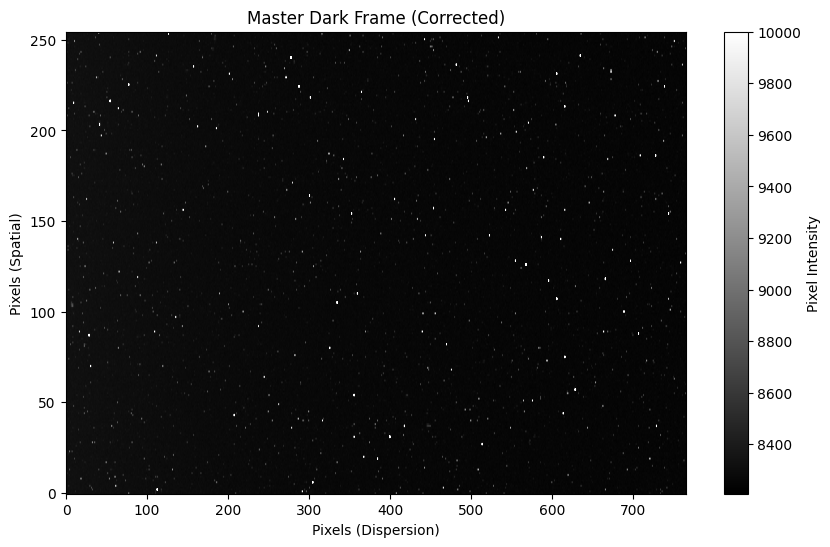

In [5]:
def create_master_dark(dark_frames):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """
    # Create the master dark frame by median-combining the dark frames
    dark_data_list = [frame[1] for frame in dark_frames]  # Extract the 'data' part from each dark frame
    master_dark = np.median(np.stack(dark_data_list), axis=0)
    # Filter the master dark frame
    # master_dark[master_dark > 8500] = 8500  # Clamp values above 9000
    # Plotting the master dark frame with a maximum value of 9000
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark, cmap='gray', origin='lower', aspect='auto', vmax=10000)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame (Corrected)')
    plt.grid(False)
    plt.show()

    return master_dark

# Example call to the function 
master_dark_corrected = create_master_dark(dark_frames)

In [6]:
def create_median_images(spectra_frames, master_dark_corrected, row_start=0, row_end=110):
    """
    Subtract the master dark frame from each star's frames, crop the y-axis to the specified spectral region,
    and compute the median image for each star.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                           Each list contains tuples of (header, data), where `data` is a 2D numpy array.
    :type spectra_frames: tuple of lists of tuples
    :param master_dark_corrected: The master dark frame to be subtracted.
    :type master_dark_corrected: np.ndarray
    :param row_start: The starting index for the row range (y-axis) to crop the image.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the image.
    :type row_end: int
    :return: A list of median images for each star after dark subtraction and cropping.
    :rtype: list of np.ndarray
    """
    median_images = []
    # Subtract the master dark from each star's frames, crop the spectral region, and compute the median
    for frames in spectra_frames:
        star_data_list = [frame[1] for frame in frames]  # Extract the 'data' part from each star frame
        corrected_images = [data - master_dark_corrected for data in star_data_list]  # Subtract the master dark
        cropped_images = [img[row_start:row_end, :] for img in corrected_images]  # Crop the y-axis
        # Compute the median image for the cropped spectral region
        median_image = np.median(np.stack(cropped_images), axis=0)
        median_images.append(median_image)

    return median_images

# Example call to the function
spectra_frames = (star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames)
median_images = create_median_images(spectra_frames, master_dark_corrected)

# Optional: Plot the cropped median images for each star
# for i, median_image in enumerate(median_images):
    # plt.figure(figsize=(10, 6))
    # plt.imshow(median_image, cmap='gray', origin='lower', aspect='auto')
    # plt.colorbar(label='Pixel Intensity')
    # plt.title(f'Cropped Median Image for Star {i+1} (Rows {0} to {110})')
    # plt.xlabel('Pixels (Dispersion)')
    # plt.ylabel('Pixels (Spatial)')
    # plt.grid(False)
    # plt.show()

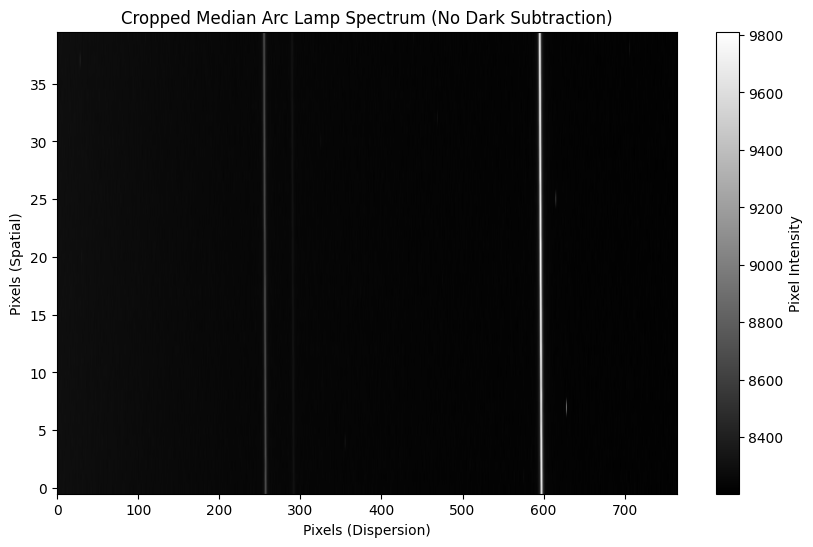

In [7]:
def create_median_arc_spectrum(arc_lamp_spectrum, row_start=50, row_end=90):
    """
    Compute the median arc lamp spectrum by cropping the y-axis to the specified spectral region 
    without subtracting the master dark frame.

    :param arc_lamp_spectrum: List of tuples containing headers and data for the arc lamp spectrum.
                              Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type arc_lamp_spectrum: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the spectrum.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the spectrum.
    :type row_end: int
    :return: Median arc lamp spectrum after cropping.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    return median_arc_spectrum

# Calling the function
median_arc_spectrum = create_median_arc_spectrum(arc_lamp_spectrum)

# Optional: Plot the median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(median_arc_spectrum, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Cropped Median Arc Lamp Spectrum (No Dark Subtraction)')
plt.grid(False)
plt.show()

##### Section 1.2: Flat-Fielding

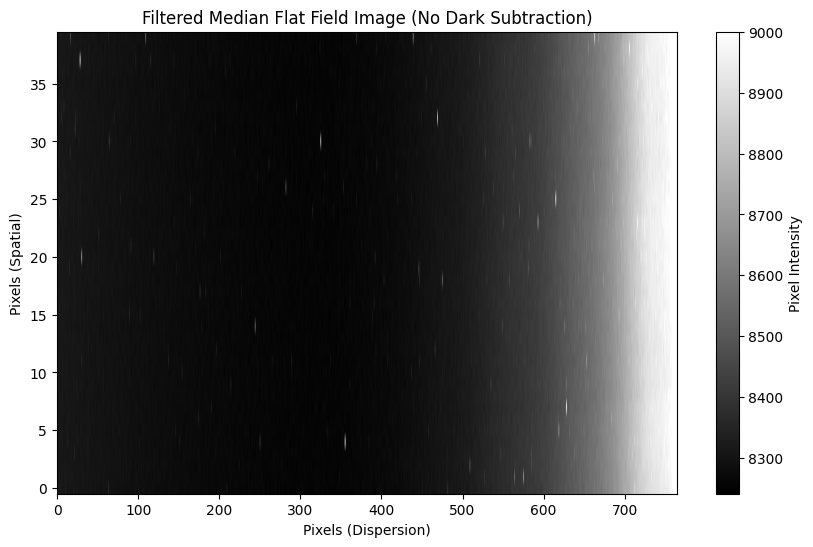

In [8]:
def median_flat_field(flat_fields, row_start=50, row_end=90):
    """
    Compute the median flat field image without subtracting the master dark frame,
    crop the y-axis to the specified region, and clamp values above 9000.

    :param flat_fields: List of tuples containing headers and 2D numpy array data for flat field frames.
    :type flat_fields: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the flat fields.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the flat fields.
    :type row_end: int
    :return: The median flat field image cropped to the specified region and filtered.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each flat field frame and crop the y-axis
    flat_field_data_list = [frame[1][row_start:row_end, :] for frame in flat_fields]
    # Create the median flat field image from the flat fields (no dark subtraction)
    median_flat_field_image = np.median(np.stack(flat_field_data_list), axis=0)
    # Clamp values above 9000
    median_flat_field_image[median_flat_field_image > 9000] = 9000
    
    return median_flat_field_image

# Calling the function
median_flat_field_image = median_flat_field(flat_fields)

# Optional: Plotting the filtered median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(median_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Filtered Median Flat Field Image (No Dark Subtraction)')
plt.grid(False)
plt.show()

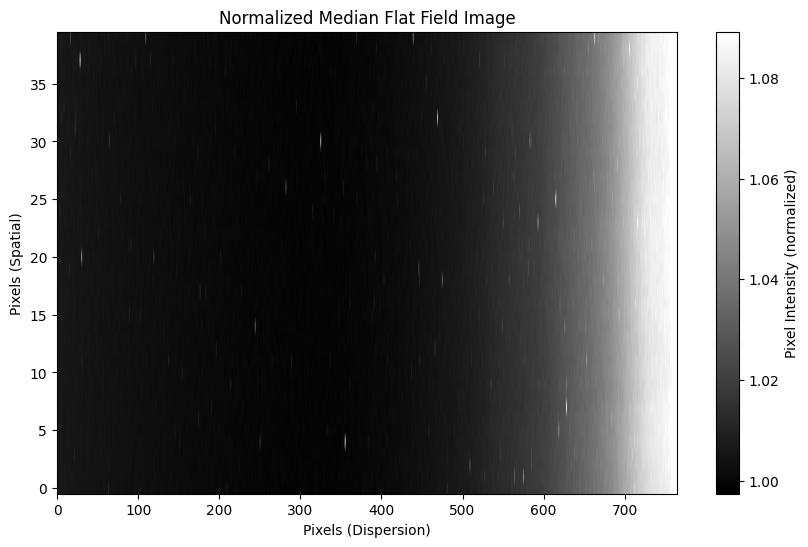

In [9]:
def normalize_flat_field(median_flat_field_image):
    """
    Normalize the median flat field image by dividing it by its mode.

    :param median_flat_field_image: The median flat field image to be normalized.
    :type median_flat_field_image: np.ndarray
    :return: The normalized median flat field image.
    :rtype: np.ndarray
    """
    # Calculate the mode for normalization
    mode_value = stats.mode(median_flat_field_image, axis=None, keepdims=True).mode[0]
    # Normalize the median flat field by dividing by its mode
    if mode_value != 0:  # Avoid division by zero
        normalized_flat_field = median_flat_field_image / mode_value
    else:
        print("Mode value is zero, skipping normalization.")
        normalized_flat_field = median_flat_field_image

    return normalized_flat_field

# Calling the function 
normalized_flat_field_image = normalize_flat_field(median_flat_field_image)

# Optional: Plotting the normalized median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(normalized_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity (normalized)')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Normalized Median Flat Field Image')
plt.grid(False)
plt.show()

##### Section 1.3: Normalize each spectrum to flat-field spectrum

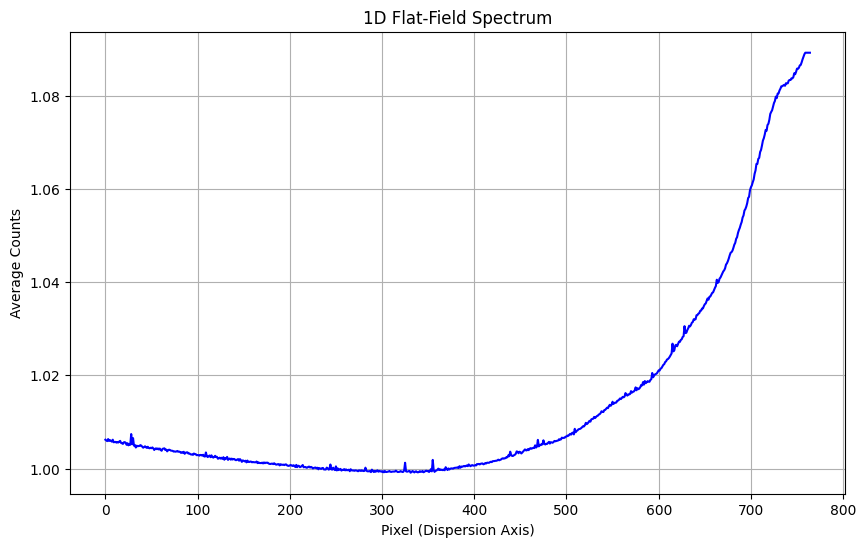

In [10]:
def collapse_flat_field_1d(normalized_flat_field_image):
    """
    Collapse the 2D normalized flat field image to a 1D spectrum
    by averaging the counts in each column.

    :param normalized_flat_field_image: The normalized median flat field image.
    :type normalized_flat_field_image: np.ndarray
    :return: 1D array of averaged counts.
    :rtype: np.ndarray
    """
    # Collapse the 2D image to a 1D array by taking the mean of each column
    flat_1d = np.mean(normalized_flat_field_image, axis=0)
    # Plot the 1D flat-field values against pixel positions
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, color='blue')
    plt.title('1D Flat-Field Spectrum')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.grid(True)
    plt.show()

    return flat_1d

# Calling the function
flat_1d = collapse_flat_field_1d(normalized_flat_field_image)

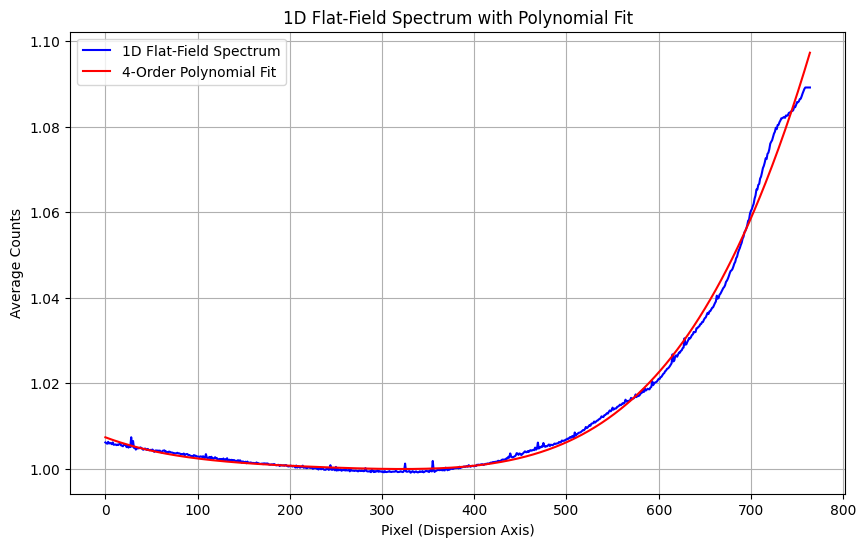

In [11]:
def fit_polynomial_to_flat_field(flat_1d, degree=4):
    """
    Fit a polynomial to the 1D flat-field spectrum and plot the results.

    :param flat_1d: The 1D array of averaged counts from the flat-field image.
    :type flat_1d: np.ndarray
    :param degree: The degree of the polynomial to fit (default is 4).
    :type degree: int
    :return: Coefficients of the fitted polynomial.
    :rtype: np.ndarray
    """
    # Fit a polynomial to the 1D flat-field data
    x_axis = np.arange(len(flat_1d))
    polynomial_fit = Polynomial.fit(x_axis, flat_1d, deg=degree)
    # Evaluate the polynomial fit
    fit_values = polynomial_fit(x_axis)
    # Plot the 1D flat-field values and the polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, label='1D Flat-Field Spectrum', color='blue')
    plt.plot(fit_values, label=f'{degree}-Order Polynomial Fit', color='red')
    plt.title('1D Flat-Field Spectrum with Polynomial Fit')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the polynomial coefficients
    return polynomial_fit.convert().coef

# Example call
polynomial_coefficients = fit_polynomial_to_flat_field(flat_1d)

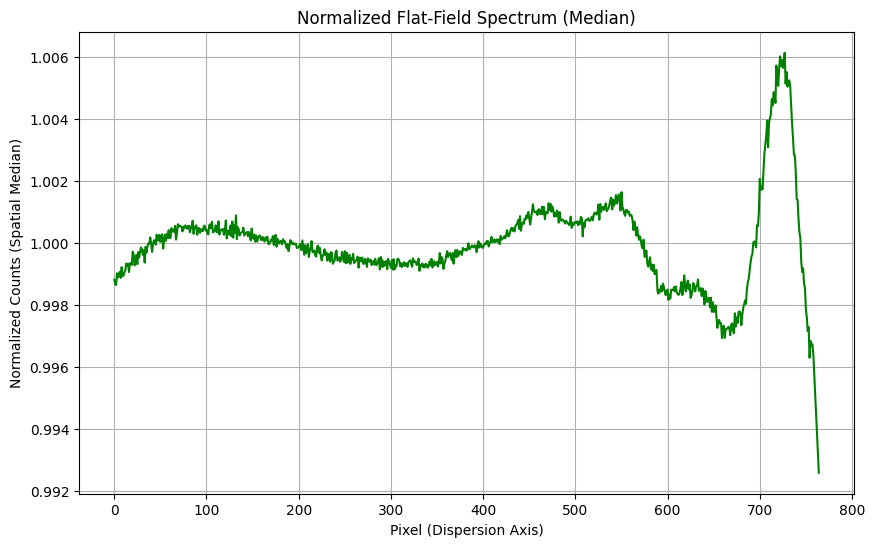

In [12]:
def normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients):
    """
    Normalize the 2D flat-field image by dividing each row by the fitted polynomial.

    :param normalized_flat_field_image: The 2D array representing the normalized flat-field image.
    :type normalized_flat_field_image: np.ndarray
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :return: The normalized flat-field image.
    :rtype: np.ndarray
    """
    # Generate the x-axis corresponding to the columns of the flat field
    x_axis = np.arange(normalized_flat_field_image.shape[1])
    # Evaluate the polynomial fit at each x position
    polynomial_fit_values = Polynomial(polynomial_coefficients)(x_axis)
    # Normalize the flat field by dividing each row by the polynomial fit values
    normalized_flat_field_poly = np.array([i / polynomial_fit_values for i in normalized_flat_field_image])

    # Plot the median normalized flat field along the dispersion axis
    plt.figure(figsize=(10, 6))
    plt.plot(np.median(normalized_flat_field_poly, axis=0), color='green')
    plt.title('Normalized Flat-Field Spectrum (Median)')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Normalized Counts (Spatial Median)')
    plt.grid(True)
    plt.show()

    return normalized_flat_field_poly

# Example call
normalized_flat_field_poly = normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients)

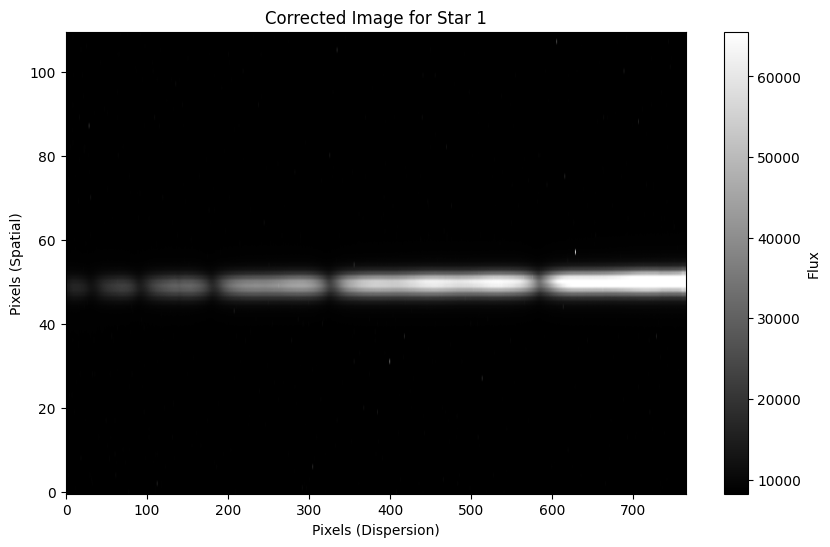

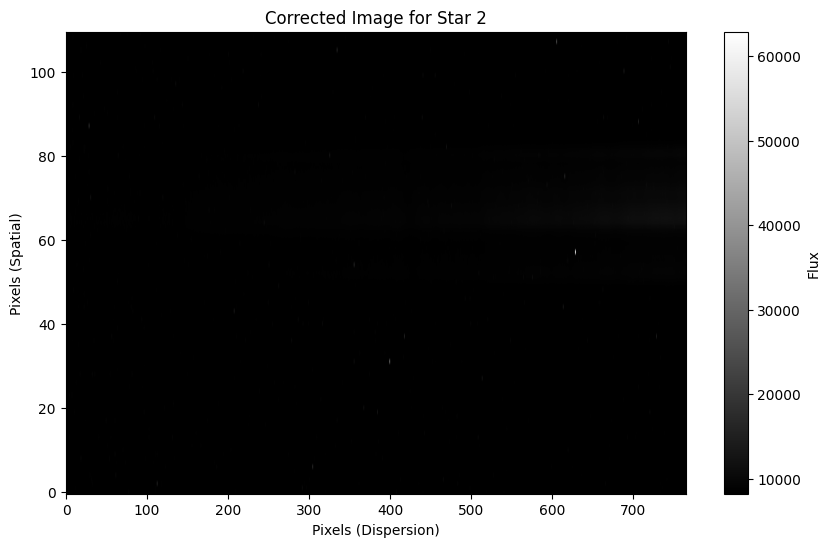

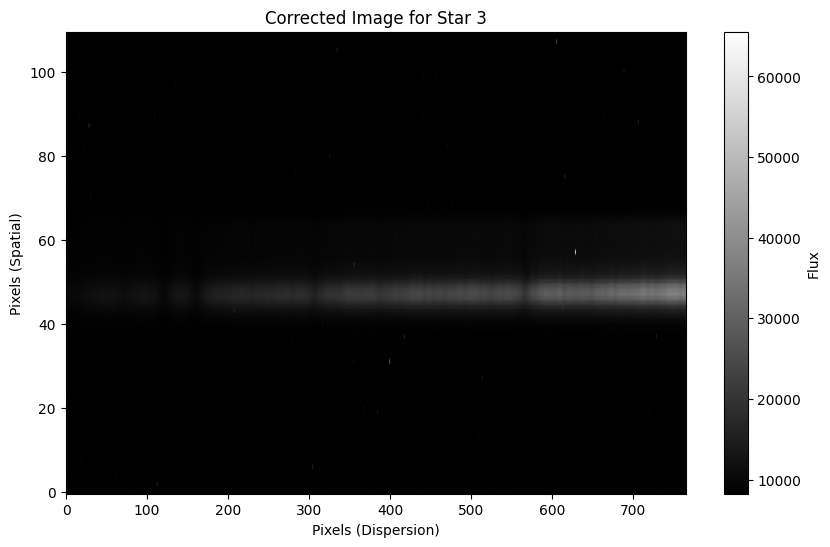

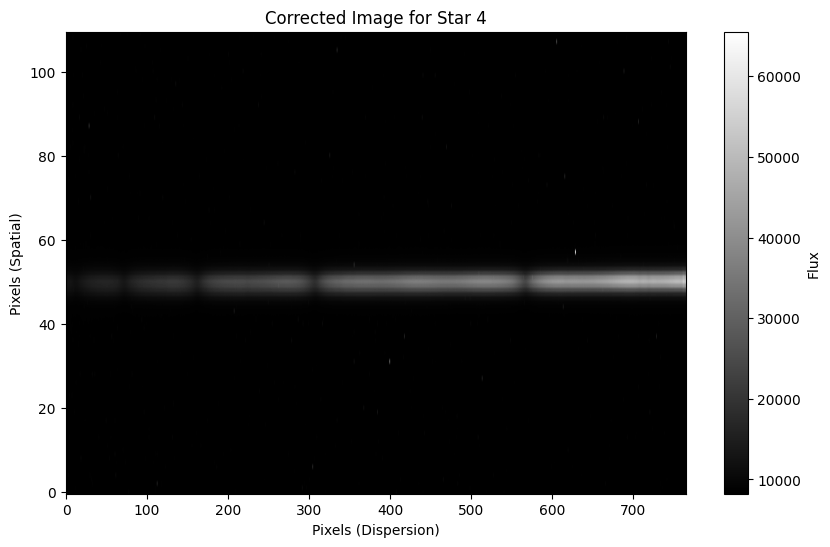

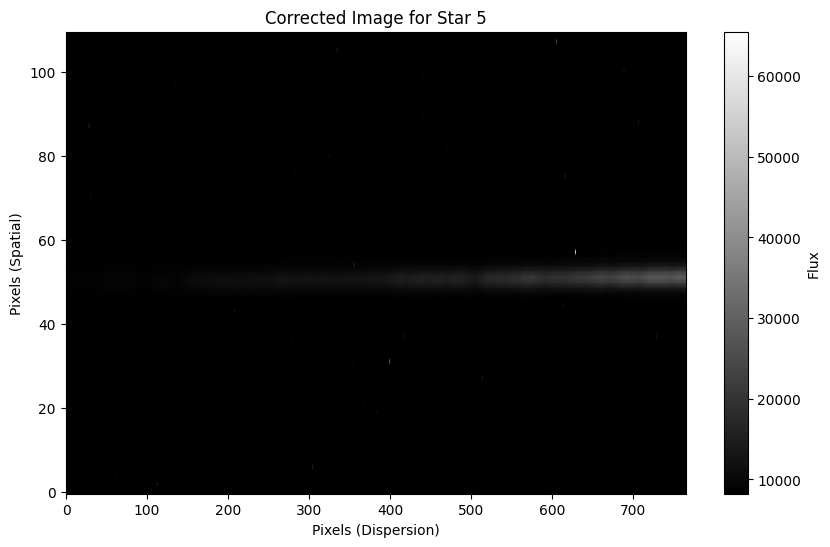

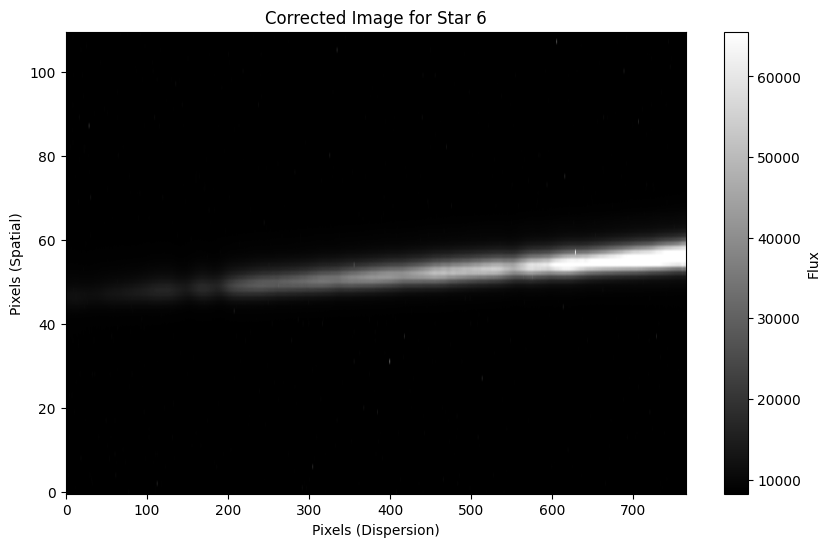

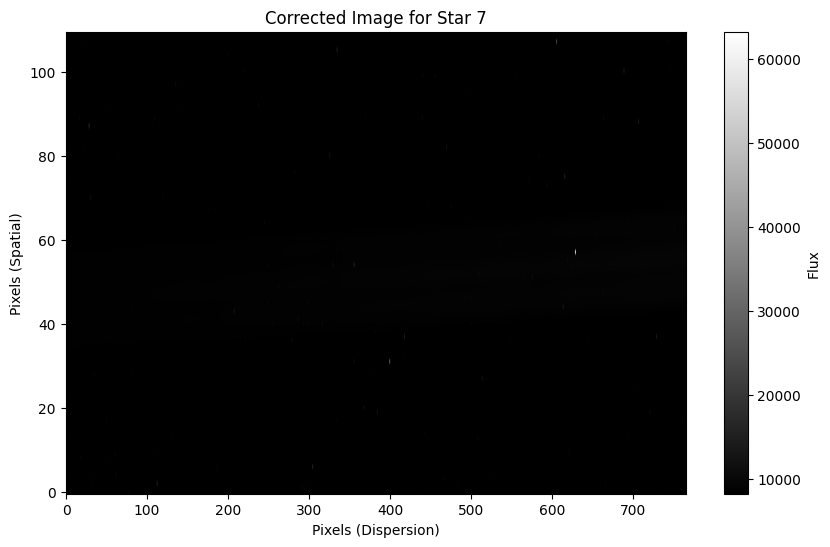

In [13]:
def correct_science_images(spectra_frames, normalized_flat_field_from_polynomial, row_start=0, row_end=110):
    """
    Correct each science image by dividing it by the normalized flat field from polynomial fitting
    and cropping the spectra frames.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                          Each list contains tuples of (header, data).
    :type spectra_frames: tuple of lists of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :return: A list of corrected and cropped science images for each star.
    :rtype: list of np.ndarray
    """
    corrected_images = []
    # Iterate over each star's frames
    for frames in spectra_frames:
        # Extract the 'data' part from each star frame
        star_data_list = [frame[1] for frame in frames]  
        # Calculate the median image across the star data
        median_star_image = np.median(star_data_list, axis=0)
        # Divide the median star image by the normalized flat field and crop the image
        corrected_image = median_star_image[row_start:row_end, :] / np.median(normalized_flat_field_from_polynomial)
        corrected_images.append(corrected_image)

    return corrected_images

# Calling the function 
corrected_spectra_images = correct_science_images(spectra_frames, normalized_flat_field_poly)

# Optional: Plotting the corrected images for each star
for star_index, corrected_image in enumerate(corrected_spectra_images):
    plt.figure(figsize=(10, 6))
    plt.imshow(corrected_image, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Flux')
    plt.title(f'Corrected Image for Star {star_index + 1}')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.grid(False)
    plt.show()

Corrected median arc spectrum saved to corrected_median_arc_spectrum.fits


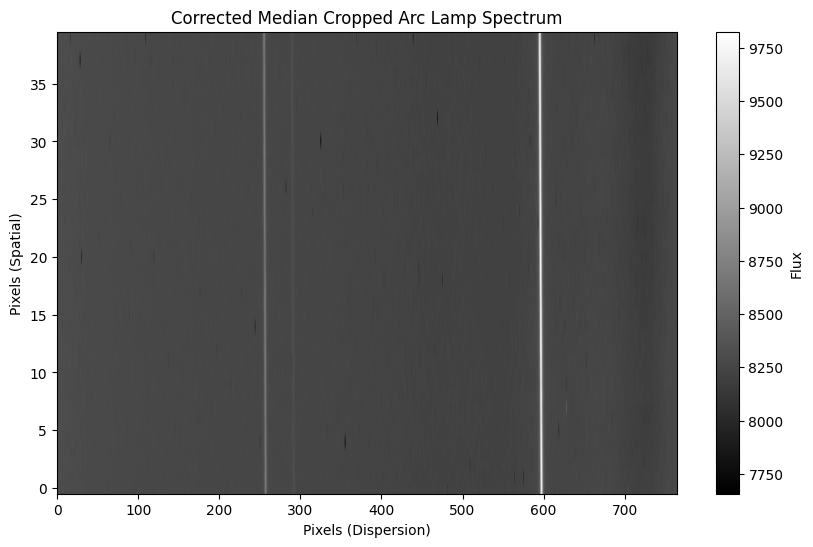

In [14]:
def correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_from_polynomial, row_start=50, row_end=90, output_filename='corrected_median_arc_spectrum.fits'):
    """
    Correct the arc lamp spectrum by taking the median of the cropped spectra frames
    and dividing by the normalized flat field from polynomial fitting.

    :param arc_lamp_spectrum: A list containing tuples of (header, data) for the arc lamp frames.
    :type arc_lamp_spectrum: list of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :param output_filename: Name of the output FITS file.
    :type output_filename: str
    :return: The corrected median arc lamp spectrum.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    # Divide the median arc spectrum by the normalized flat field
    corrected_median_arc_spectrum = median_arc_spectrum / normalized_flat_field_from_polynomial
    
    # Save the corrected median arc spectrum to a FITS file
    hdu = fits.PrimaryHDU(corrected_median_arc_spectrum)
    hdu.writeto(output_filename, overwrite=True)
    print(f"Corrected median arc spectrum saved to {output_filename}")

    return corrected_median_arc_spectrum

# Calling the function
corrected_median_arc_image = correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_poly)

# Optional: Plotting the corrected median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(corrected_median_arc_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Flux')
plt.title('Corrected Median Cropped Arc Lamp Spectrum')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.grid(False)
plt.show()

##### Section 1.4: Wavelength calibration

In [15]:
def extract_target_sky_flux(corrected_image, star_index):
    """
    Extract the target and sky flux from the corrected spectra image and compute the 1D spectrum.

    :param corrected_image: The corrected and cropped science image.
    :type corrected_image: np.ndarray
    :param star_index: Index of the star to extract target and sky flux for.
    :type star_index: int
    :return: The 1D object flux and sky flux.
    :rtype: tuple of np.ndarray
    """
    # Define row ranges for target and sky extraction
    row_ranges = { 
        0: {'target': (45, 55), 'sky': (60, 65)},   # Star 1
        1: {'target': (50, 80), 'sky': (85, 90)},   # Star 2
        2: {'target': (40, 68), 'sky': (70, 75)},   # Star 3
        3: {'target': (45, 55), 'sky': (60, 65)},   # Star 4
        4: {'target': (46, 56), 'sky': (60, 65)},   # Star 5
        5: {'target': (45, 60), 'sky': (65, 70)},   # Star 6
        6: {'target': (35, 68), 'sky': (70, 75)}    # Star 7
    }

    # Get the row ranges for the specified star
    target_rows = row_ranges[star_index]['target']
    sky_rows = row_ranges[star_index]['sky']
    
    # Crop target and sky regions using the new row_start and row_end variables
    target_region = corrected_image[target_rows[0]:target_rows[1], :]
    sky_region = corrected_image[sky_rows[0]:sky_rows[1], :]
    
    # Sum the flux in the target and sky regions along the spatial axis (rows)
    target_flux = np.sum(target_region, axis=0)
    sky_flux = np.mean(sky_region, axis=0)  # Average sky background across rows
    
    # Subtract sky background from target flux
    object_flux = target_flux - sky_flux
    
    return object_flux, sky_flux

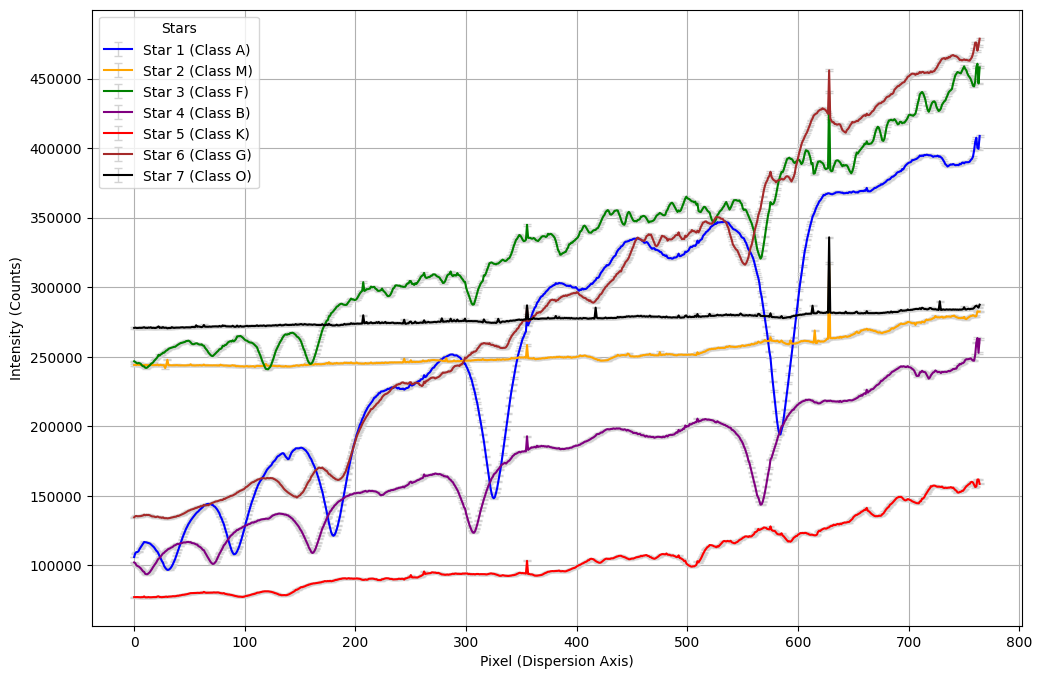

In [16]:
def calculate_poisson_uncertainties(object_flux, sky_flux):
    """
    Calculate Poisson uncertainties for the object flux.

    :param object_flux: The 1D array of object flux.
    :type object_flux: np.ndarray
    :param sky_flux: The 1D array of sky flux.
    :type sky_flux: np.ndarray
    :return: The 1D array of Poisson uncertainties.
    :rtype: np.ndarray
    """
    # Poisson uncertainties directly from the object and sky flux
    object_poisson = np.sqrt(np.clip(object_flux, 0, None))  # Poisson uncertainty for object flux
    sky_poisson = np.sqrt(np.clip(sky_flux, 0, None))        # Poisson uncertainty for sky flux
    # Total uncertainty from object and sky Poisson distributions
    total_uncertainties = np.sqrt(object_poisson**2 + sky_poisson**2)
    
    return total_uncertainties

# Mapping of star indices to their spectral classes
star_classes = {
    0: 'A', 1: 'M', 2: 'F', 3: 'B', 4: 'K', 5: 'G', 6: 'O'
}

# Prepare a single figure for plotting all star spectra
plt.figure(figsize=(12, 8))

# Define colors for each star (adjust if more stars are added)
colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'black']

# Process each star's corrected spectra image individually and plot on the same figure
for i, corrected_image in enumerate(corrected_spectra_images):
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    
    # Get the spectral class for each star and plot with appropriate color and label
    star_class = star_classes.get(i, "Unknown")
    plt.errorbar(
        np.arange(len(object_flux)), object_flux, yerr=poisson_uncertainties, 
        fmt='-', color=colors[i % len(colors)], 
        label=f'Star {i+1} (Class {star_class})', 
        ecolor='lightgray', elinewidth=1, capsize=3
    )

# Customize the plot
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Intensity (Counts)')
plt.legend(title="Stars", loc='upper left')
plt.grid(True)

# Show the combined plot
plt.show()

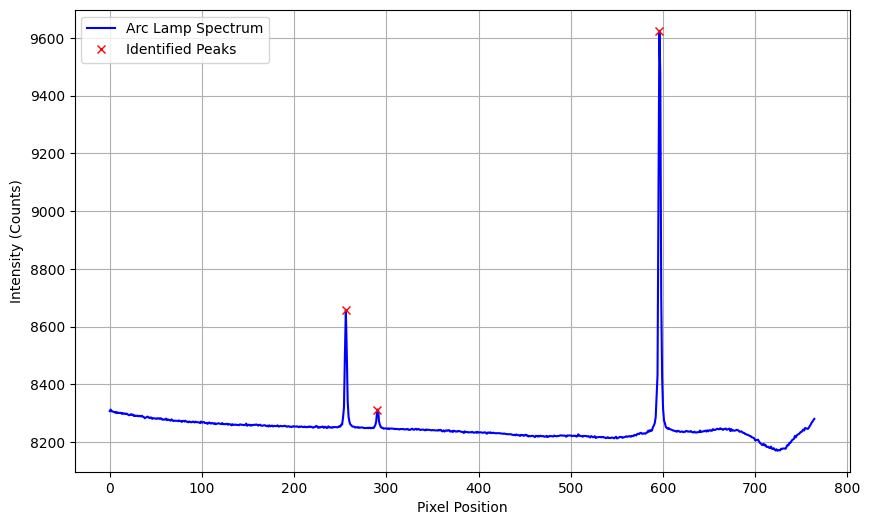

In [17]:
def analyze_arc_lamp_spectrum(corrected_median_arc_image, height_threshold=112, prominence_threshold=20):
    """
    Analyze the corrected arc lamp spectrum by collapsing it to 1D,
    identifying peaks based on height and prominence, and plotting the resulting spectrum.

    :param corrected_median_arc_image: 2D array containing the corrected arc lamp spectrum.
    :type corrected_median_arc_image: np.ndarray
    :param height_threshold: The height threshold for identifying peaks in the spectrum (default is 112).
    :type height_threshold: int, optional
    :param prominence_threshold: The minimum prominence for peaks (default is 20: DON'T CHANGE THIS).
    :type prominence_threshold: int, optional
    :return: 1D array of the arc lamp spectrum and indices of identified peaks.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Collapse the 2D arc lamp spectrum to 1D by taking the median along the spatial axis
    arc_lamp_spectrum_1d = np.median(corrected_median_arc_image, axis=0)
    # Identify peaks in the arc lamp spectrum using specified thresholds
    peak_indices, properties = find_peaks(arc_lamp_spectrum_1d, height=height_threshold, prominence=prominence_threshold)
    
    # Plot the arc lamp spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(arc_lamp_spectrum_1d, label='Arc Lamp Spectrum', color='blue')
    plt.plot(peak_indices, arc_lamp_spectrum_1d[peak_indices], 'rx', label='Identified Peaks')
    # Customize plot appearance
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

    return arc_lamp_spectrum_1d, peak_indices

# Calling the function
arc_lamp_spectrum_1d, peak_indices = analyze_arc_lamp_spectrum(corrected_median_arc_image)

In [18]:
def print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices):
    """
    Retrieve the pixel positions and corresponding intensities of the identified peaks in the 
    arc lamp spectrum.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum.
    :type arc_lamp_spectrum_1d: np.ndarray
    :param peak_indices: 1D array containing the indices of the identified peaks.
    :type peak_indices: np.ndarray
    :return: A tuple of the peak pixel indices and corresponding intensities.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Extract the peak intensities at the identified peak indices
    peak_intensities = arc_lamp_spectrum_1d[peak_indices]
    return peak_indices, peak_intensities

# Calling the function
peak_indices, peak_intensities = print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices)

# Displaying the results
for idx, intensity in zip(peak_indices, peak_intensities):
    print(f"Peak at pixel {idx}: Intensity = {intensity}")

Peak at pixel 256: Intensity = 8657.94791435945
Peak at pixel 290: Intensity = 8312.983308259725
Peak at pixel 596: Intensity = 9624.305219313537


Pixel Position | Wavelength (nm)
------------------------------
            256 |          404.77
            290 |          407.90
            596 |          435.95


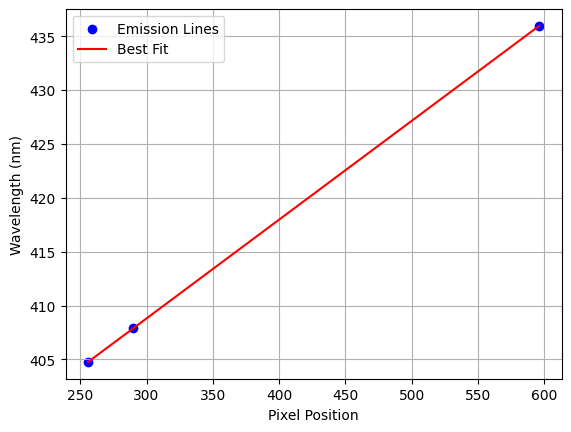

Linear Coefficients: Slope = 0.0917083063994823 nm, Intercept = 381.2973713639303 nm


In [19]:
def fit_wavelengths_to_peaks(peak_indices):
    """
    Fit the identified peak indices to known wavelengths, outputs table of pixel positions 
    and their wavelengths, and generates a calibration graph, returning the model coefficients.
    
    :param peak_indices: 1D array containing the indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    :return: A tuple containing the coefficients of the linear fit (slope, intercept).
    :rtype: tuple(float, float)
    """
    # Known wavelengths corresponding to the identified peaks in nanometers
    known_wavelengths = [404.77, 407.898, 435.955]
    # Ensure the number of peaks matches the number of known wavelengths
    if len(peak_indices) != len(known_wavelengths):
        raise ValueError("Number of identified peaks does not match the number of known wavelengths.")
    # Fit a linear model to the data
    linear_model = models.Linear1D()
    fitter = fitting.LinearLSQFitter()
    # Perform the fitting
    best_fit = fitter(linear_model, peak_indices, known_wavelengths)
    # Generate the table of pixel positions and wavelengths
    print("Pixel Position | Wavelength (nm)")
    print("-" * 30)
    for pixel_position, wavelength in zip(peak_indices, known_wavelengths):
        print(f"{pixel_position:15d} | {wavelength:15.2f}")

    # Plot the data and the best-fit linear line
    plt.scatter(peak_indices, known_wavelengths, color='blue', label='Emission Lines')
    plt.plot(np.sort(peak_indices), best_fit(np.sort(peak_indices)), color='red', label='Best Fit')
    plt.xlabel('Pixel Position')
    plt.ylabel('Wavelength (nm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Output the linear coefficients
    coefficients = (best_fit.slope.value, best_fit.intercept.value)
    print(f"Linear Coefficients: Slope = {coefficients[0]} nm, Intercept = {coefficients[1]} nm")
    
    return coefficients

# Calling the function 
coefficients = fit_wavelengths_to_peaks(peak_indices)

In [20]:
def convert_dispersion_to_nanometers(object_flux, coefficients):
    """
    Convert the x-axis of the object flux from counts to nanometers.

    :param object_flux: 1D array containing the object flux (in intensity/counts).
    :type object_flux: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :return: wavelengths in nanometers and the converted object flux.
    :rtype: tuple (np.ndarray, np.ndarray)
    """
    # Extract linear coefficients: slope (a) and intercept (b)
    slope, intercept = coefficients  
    # Convert pixel positions to wavelengths (nanometers) using the linear fit
    pixel_positions = np.arange(len(object_flux))
    wavelengths = (slope * pixel_positions) + intercept

    return wavelengths, object_flux

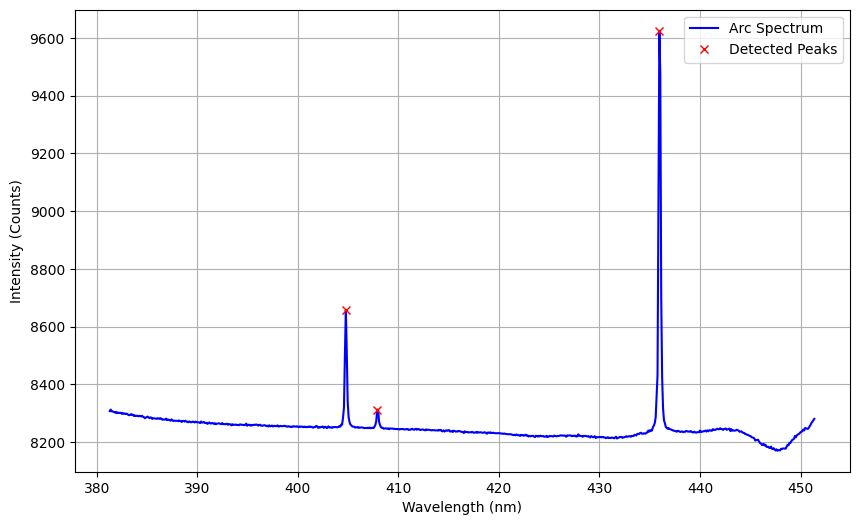

In [21]:
def process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices):
    """
    Process the arc lamp spectrum by converting to wavelengths and plotting the results.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum (in intensity/counts).
    :type arc_lamp_spectrum_1d: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :param peak_indices: Indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    """
    # Convert the spectrum to wavelengths
    wavelengths, converted_spectrum = convert_dispersion_to_nanometers(arc_lamp_spectrum_1d, coefficients)
    # Plot the flat-corrected arc spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_spectrum, label='Arc Spectrum', color='blue')
    # Mark the peaks with an 'x' symbol
    plt.plot(wavelengths[peak_indices], converted_spectrum[peak_indices], 'x', color='red', label="Detected Peaks")
    # Set plot titles and labels
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

# Calling the functions 
process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices)

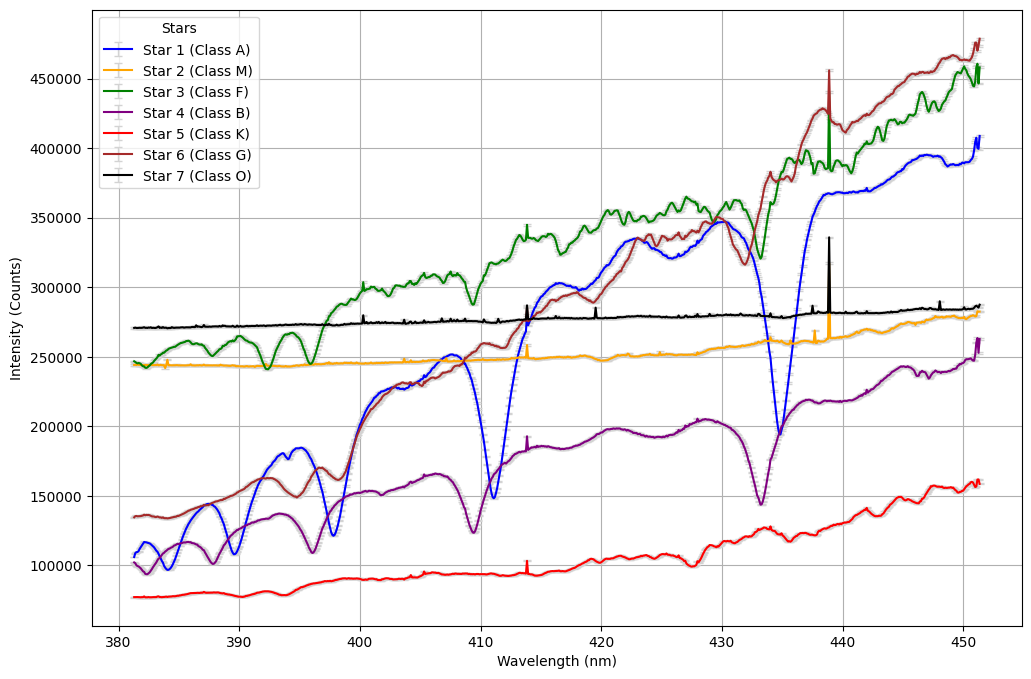

In [22]:
def process_star_spectra(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save a combined plot.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    """
    # Mapping of star indices to their spectral classes
    star_classes = {
        0: 'A', 1: 'M', 2: 'F', 3: 'B', 4: 'K', 5: 'G', 6: 'O'
    }

    # Prepare a single figure for plotting all star spectra
    plt.figure(figsize=(12, 8))

    # Define colors for each star (adjust if more stars are added)
    colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'black']

    # Process each star's corrected spectra image individually and plot on the same figure
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Get the spectral class for each star
        star_class = star_classes.get(i, "Unknown")
        
        # Plotting the object flux and its uncertainties for each star
        plt.errorbar(
            wavelengths, converted_object_flux, yerr=poisson_uncertainties, fmt='-', 
            label=f'Star {i+1} (Class {star_class})', 
            color=colors[i % len(colors)], ecolor='lightgray', elinewidth=1, capsize=3
        )

    # Customize the plot
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.legend(title="Stars", loc='upper left')
    plt.grid(True)

    # Save the combined plot as an image file
    plt.savefig('combined_star_spectra_nanometers.png')  
    plt.show()  # Show the combined plot

# Calling the function
process_star_spectra(corrected_spectra_images, coefficients)

##### Section 2.1: Flux calibration

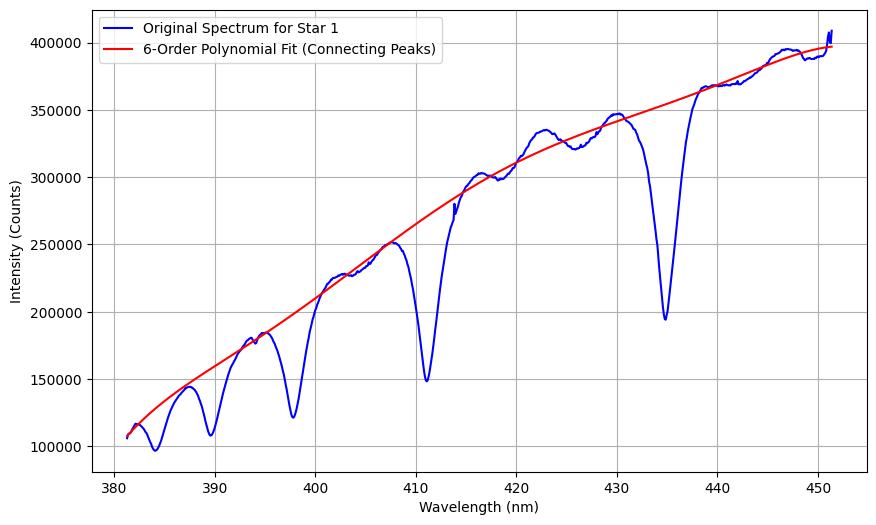

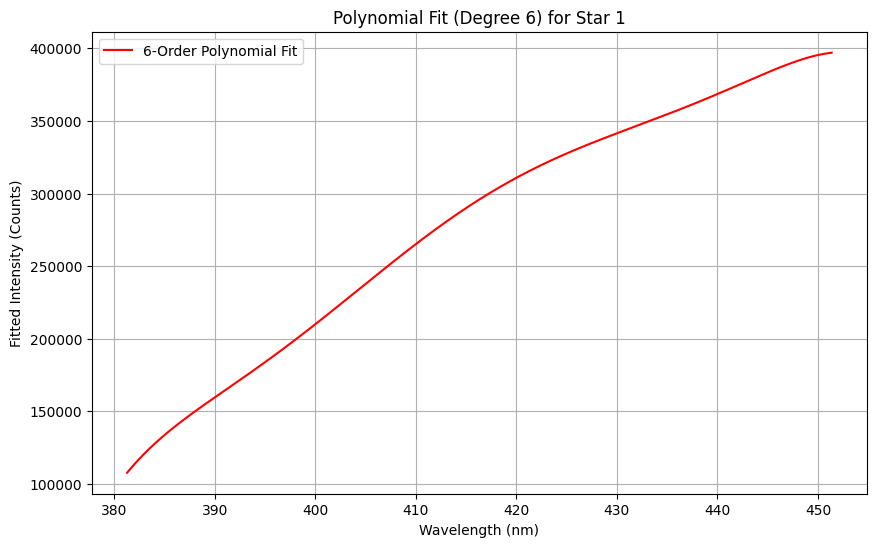

In [23]:
def process_star_spectra_Vega_Peaks_fit(corrected_spectra_images, coefficients):
    """
    Process the corrected spectra image of the first star, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Process only the first star's corrected spectra image
    corrected_image = corrected_spectra_images[0]
    # Extract object and sky flux
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=0)
    # Calculate Poisson uncertainties
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    # Convert to wavelengths (nm)
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    # Plot both the original curve and the polynomial fit for Star 1
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 1', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Only polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fitted Intensity (Counts)')
    plt.title(f'Polynomial Fit (Degree {polynomial_degree}) for Star 1')
    plt.legend()
    plt.grid(True)
    plt.show()

    return wavelengths, fit_values

# Call the function to get wavelengths and flux for the reference star
wavelengths, fit_values = process_star_spectra_Vega_Peaks_fit(corrected_spectra_images, coefficients)

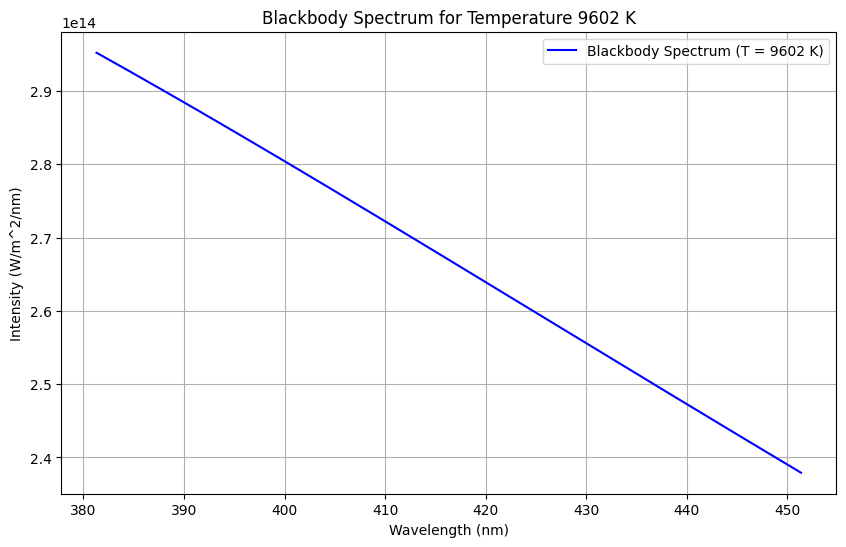

In [24]:
def calculate_blackbody_spectrum(wavelengths, temperature, h=6.626e-34, c=3.0e8, k=1.38e-23):
    """
    Calculate and optionally plot the blackbody spectrum for a given temperature.

    :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    :param h: Planck's constant in J·s (default: 6.626e-34).
    :type h: float
    :param c: Speed of light in m/s (default: 3.0e8).
    :type c: float
    :param k: Boltzmann constant in J/K (default: 1.38e-23).
    :type k: float
    :return: Blackbody spectrum.
    :rtype: np.ndarray
    """
    # Convert wavelengths from nm to meters for the calculation
    wavelengths_m = wavelengths * 1e-9
    # Calculate the blackbody radiation using Planck's law
    term1 = (2.0 * h * c**2) / (wavelengths_m**5)
    term2 = 1.0 / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)
    blackbody_spectrum = term1 * term2
    # Plot the blackbody spectrum if plot=True
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, blackbody_spectrum, label=f'Blackbody Spectrum (T = {temperature} K)', color='blue')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (W/m^2/nm)')
    plt.title(f'Blackbody Spectrum for Temperature {temperature} K')
    plt.legend()
    plt.grid(True)
    plt.show()

    return blackbody_spectrum

# Example usage
temperature = 9602  # Temperature in Kelvin
blackbody_spectrum = calculate_blackbody_spectrum(wavelengths, temperature)

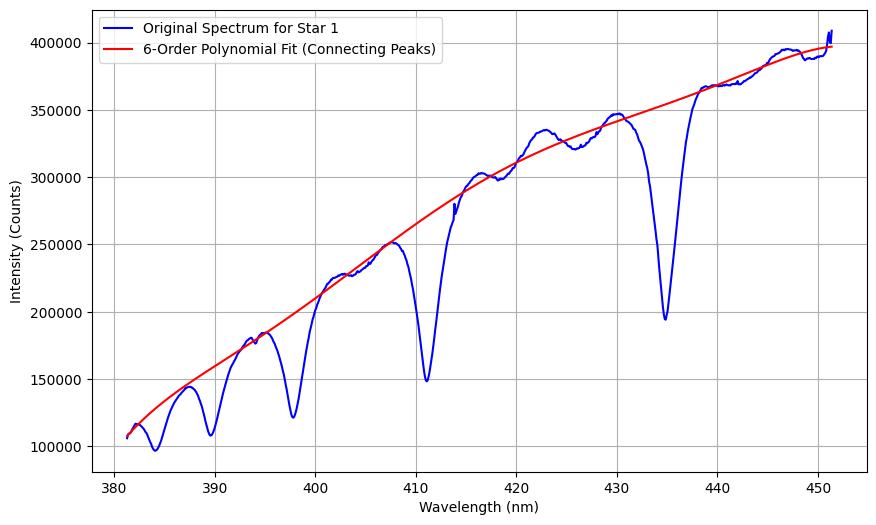

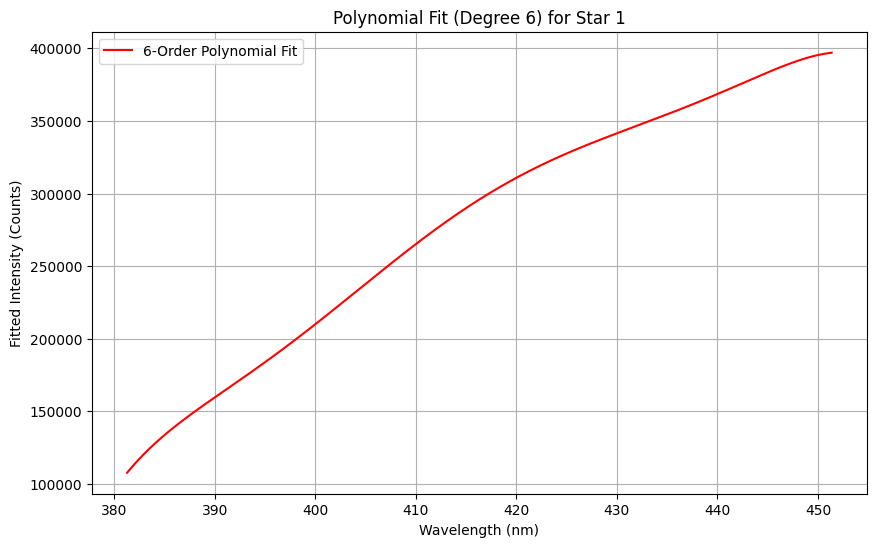

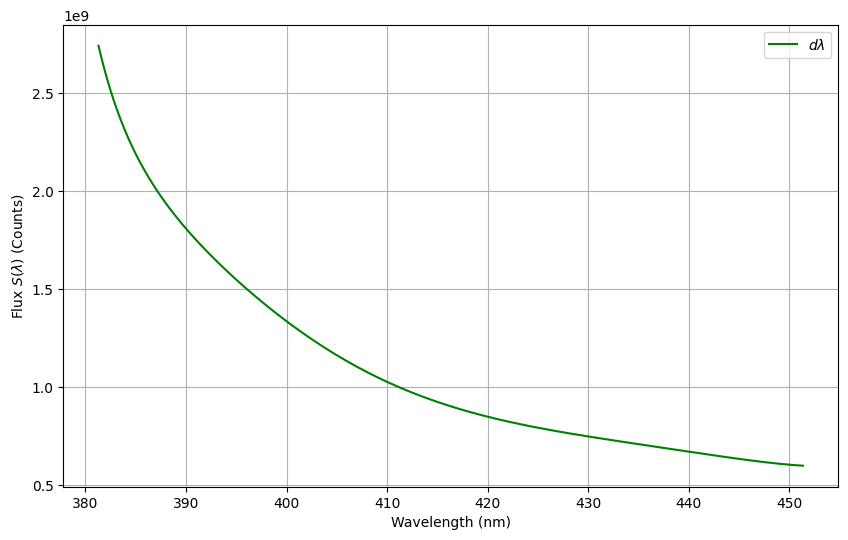

In [25]:
def calculate_d_lambda_combined_no_curve(wavelengths, temperature, corrected_spectra_images, coefficients):
    """
    Calculate the d_lambda curve by dividing the blackbody spectrum by the polynomial fit of the spectrum
    and plot the resulting d_lambda values against the wavelengths.

    :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and corresponding d_lambda values.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Step 2: Get the polynomial fit values using the process_star_spectra_Vega_Peaks_fit function
    wavelengths_fit, polynomial_fit_values = process_star_spectra_Vega_Peaks_fit(corrected_spectra_images, coefficients)
    # Step 3: Interpolate the polynomial fit values to match the blackbody spectrum wavelengths
    interpolation_function = interp1d(wavelengths_fit, polynomial_fit_values, kind='linear', fill_value="extrapolate")
    interpolated_fit_values = interpolation_function(wavelengths)
    # Step 4: Calculate d_lambda by dividing the blackbody flux by the interpolated polynomial fit values
    d_lambda = blackbody_spectrum / interpolated_fit_values

    # Step 5: Plot d_lambda as a function of wavelength
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, d_lambda, label=r'$d\lambda$', color='green')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel(r'Flux $S(\lambda)$ (Counts)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Return wavelengths and the calculated d_lambda values
    return wavelengths, d_lambda

# Calling the function
temperature = 9602
wavelengths_result, d_lambda = calculate_d_lambda_combined_no_curve(wavelengths, temperature, corrected_spectra_images, coefficients)

##### 2.2 Calibrate the fluxes of the stars

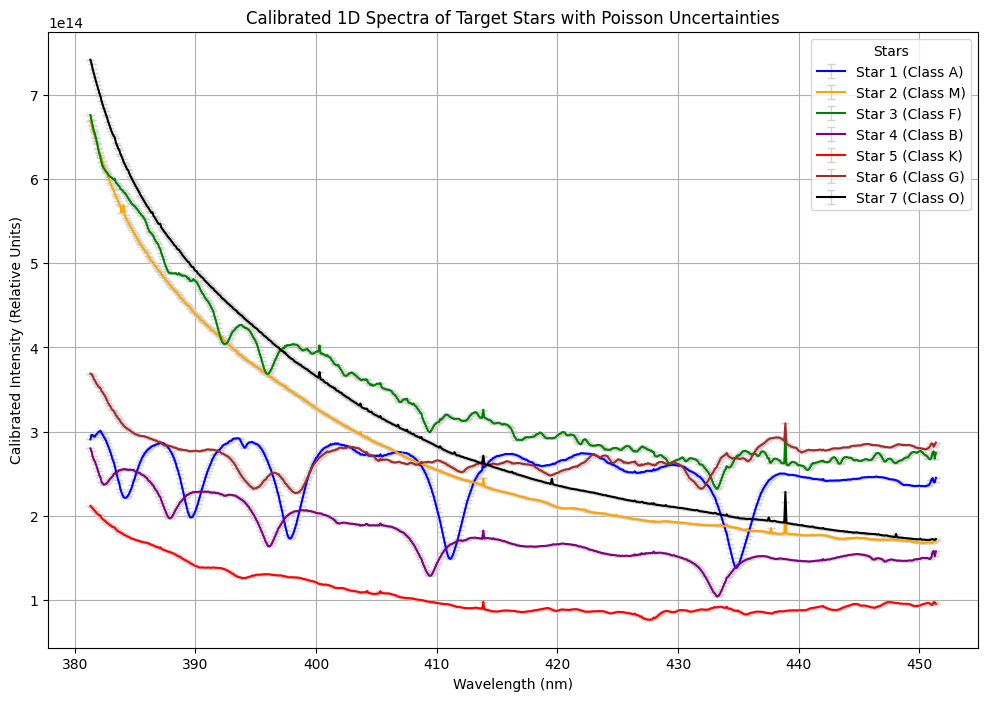

In [26]:
def process_all_spectra(corrected_spectra_images, coefficients, d_lambda):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, apply d_lambda, and save a combined plot.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param d_lambda: The d_lambda values.
    :type d_lambda: np.ndarray
    :return: List of tuples containing wavelengths and calibrated object flux for each star.
    :rtype: list of tuple(np.ndarray, np.ndarray)
    """

    calibrated_spectra = []

    # Define star spectral classes and colors for plotting
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    colors = ['blue', 'orange', 'green', 'purple', 'red', 'brown', 'black']
    
    # Prepare a single figure for plotting all calibrated spectra
    plt.figure(figsize=(12, 8))

    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux for each star's spectrum
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        
        # Calculate Poisson uncertainties for the object flux
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        
        # Convert pixel positions to wavelengths (nm) using the provided coefficients
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
                
        # Multiply the object flux by d_lambda for calibration
        calibrated_object_flux = converted_object_flux * d_lambda
        
        # Store the calibrated wavelengths and flux for later use
        calibrated_spectra.append((wavelengths, calibrated_object_flux, poisson_uncertainties))

        # Plot the calibrated object flux with uncertainties for each star
        plt.errorbar(
            wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
            label=f'Star {i+1} (Class {star_classes[i]})', 
            color=f'{colors[i % len(colors)]}', ecolor='lightgray', elinewidth=1, capsize=3
        )
    
    # Customize the plot
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Relative Units)')
    plt.title('Calibrated 1D Spectra of Target Stars with Poisson Uncertainties')
    plt.legend(title="Stars", loc='upper right')
    plt.grid(True)
    
    # Save the combined plot as an image file
    plt.savefig('combined_calibrated_star_spectra.png')  
    plt.show()  # Show the combined plot

    return calibrated_spectra

# Example usage
# Assuming d_lambda_wavelengths and d_lambda are already calculated or available
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)

##### 3.1: Strengths of the specified absorption lines

##### First Star (A): Vega

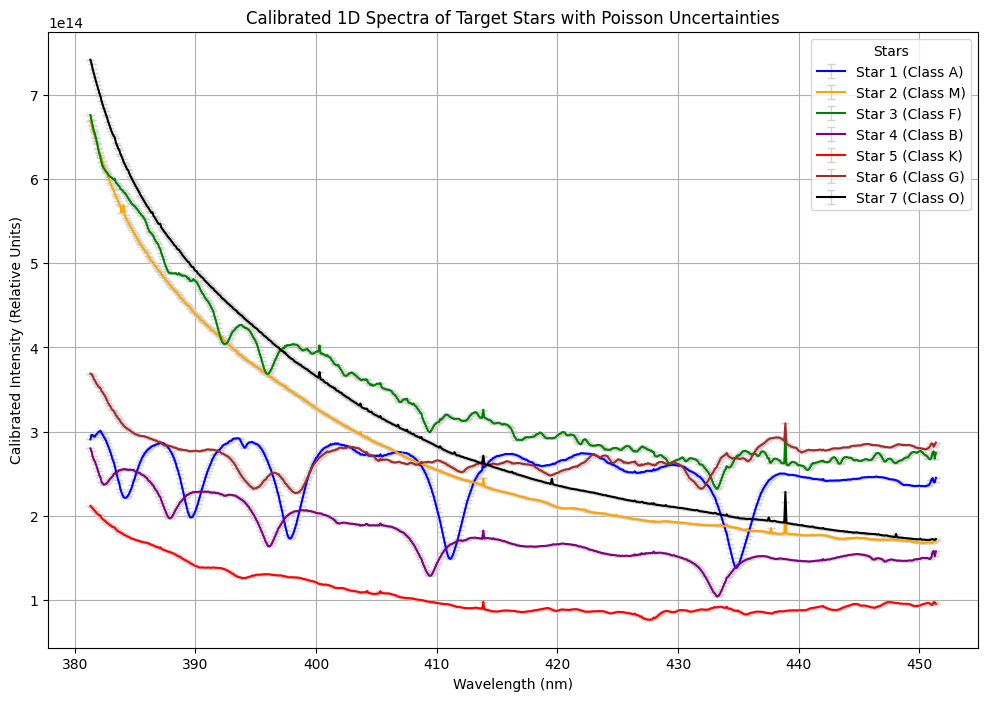

Dip 1: Wavelength = 384.14 nm, Flux = 221137628522794.28
Dip 2: Wavelength = 389.64 nm, Flux = 197815233489572.72
Dip 3: Wavelength = 397.80 nm, Flux = 172753832720383.50
Dip 4: Wavelength = 411.10 nm, Flux = 148515553845482.03
Dip 5: Wavelength = 434.86 nm, Flux = 137887272276020.50


In [27]:
def process_first_star(calibrated_spectrum, absorption_lines):
    """
    Process the calibrated spectrum for the first star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the first star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='blue', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 1 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_1_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips
absorption_lines = {
    "dip 1": (382, 385),
    "dip 2": (388, 390), 
    "dip 3": (395, 399), 
    "dip 4": (410, 412), 
    "dip 5": (433, 435)
}

# Process all spectra and get the calibrated spectrum for the first star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_first_star = calibrated_spectra[0]  # Get the first star's calibrated spectrum

# Now, process the first star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_first_star(calibrated_spectrum_first_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

In [28]:
def gaussian(x, amplitude, mean, stddev, baseline):
    """Gaussian function with baseline."""
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + baseline

In [29]:
def normalize_spectrum_to_continuum(wavelengths, flux, degree=2, dip_points=None):
    """
    Normalize the spectrum to its continuum by fitting a polynomial.
    
    :param wavelengths: Wavelengths in nm.
    :type wavelengths: np.ndarray
    :param flux: The flux values (counts).
    :type flux: np.ndarray
    :param degree: Degree of the polynomial to fit the continuum.
    :type degree: int
    :param dip_points: List of identified dips (wavelength, flux).
    :type dip_points: list
    :return: Normalized flux (continuum normalized to 1).
    :rtype: np.ndarray
    """
    mask = np.ones_like(wavelengths, dtype=bool)
    if dip_points:
        for wavelength, _ in dip_points:
            # Masking a small range around the identified dip points
            mask &= ~((wavelengths >= wavelength - 5) & (wavelengths <= wavelength + 5))
    # Fit polynomial to the continuum
    polynomial_coefficients = np.polyfit(wavelengths[mask], flux[mask], degree)
    continuum = np.polyval(polynomial_coefficients, wavelengths)
    # Normalize the flux by the continuum
    normalized_flux = flux / continuum

    return normalized_flux

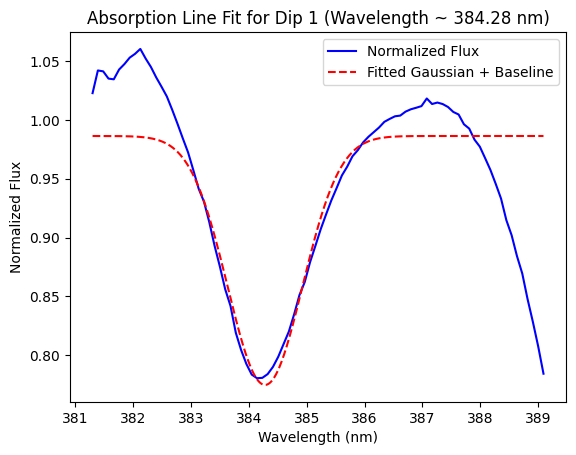

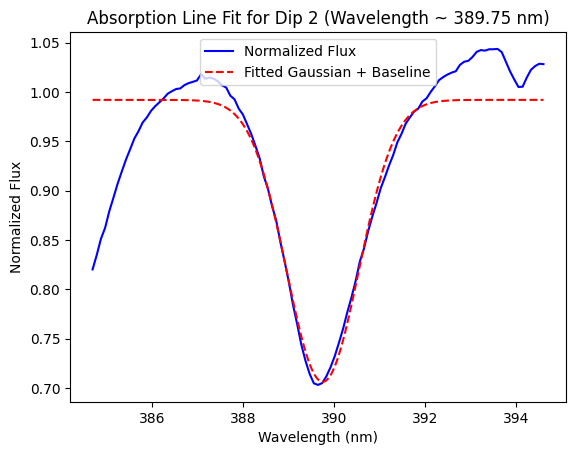

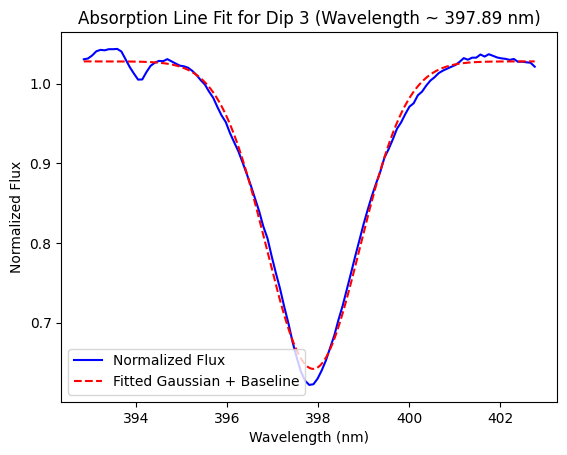

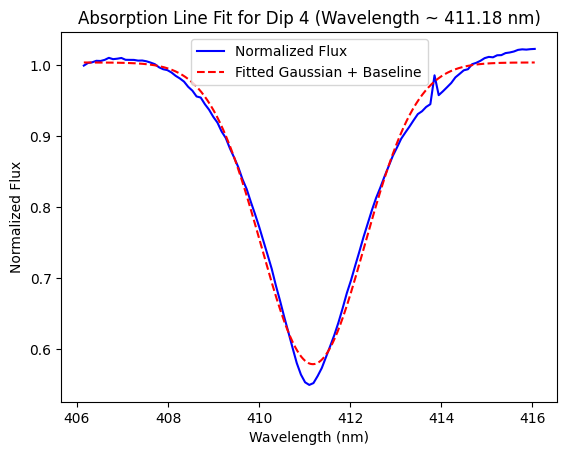

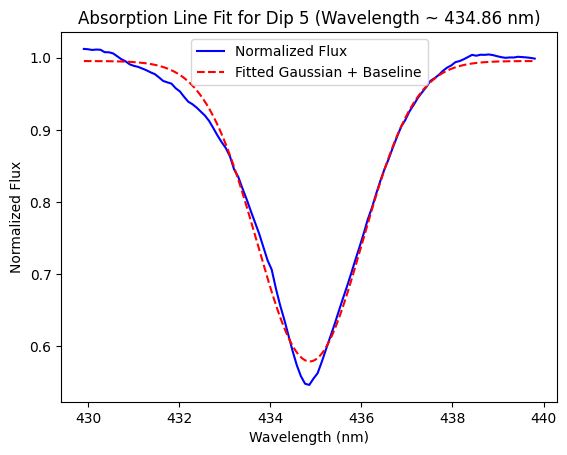

Dip 1:
  Center Wavelength (nm): 384.28
  Amplitude: -0.21
  Sigma (nm): 0.64
  Equivalent Width (nm): 0.4484

  Uncertainty in Equivalent Width (nm): 0.0633

Dip 2:
  Center Wavelength (nm): 389.75
  Amplitude: -0.29
  Sigma (nm): 0.79
  Equivalent Width (nm): 0.6459

  Uncertainty in Equivalent Width (nm): 0.0485

Dip 3:
  Center Wavelength (nm): 397.89
  Amplitude: -0.39
  Sigma (nm): 1.03
  Equivalent Width (nm): 0.7141

  Uncertainty in Equivalent Width (nm): 0.0085

Dip 4:
  Center Wavelength (nm): 411.18
  Amplitude: -0.43
  Sigma (nm): 1.14
  Equivalent Width (nm): 1.1717

  Uncertainty in Equivalent Width (nm): 0.0168

Dip 5:
  Center Wavelength (nm): 434.86
  Amplitude: -0.42
  Sigma (nm): 1.15
  Equivalent Width (nm): 1.2464

  Uncertainty in Equivalent Width (nm): 0.0191



In [30]:
def measure_absorption_lines(wavelengths, normalized_flux, dip_points):
    """
    Measure the absorption lines by fitting a Gaussian + Constant to each identified dip.
    Also plots the normalized flux and the fitted Gaussian for each dip.
    
    :param wavelengths: Wavelengths in nm.
    :type wavelengths: np.ndarray
    :param normalized_flux: Normalized flux values (continuum = 1).
    :type normalized_flux: np.ndarray
    :param dip_points: List of identified dips (wavelength, flux).
    :type dip_points: list
    :return: Dictionary with equivalent widths and Gaussian fit parameters for each line.
    :rtype: dict
    """
    line_measurements = {}
    
    for i, (wavelength, _) in enumerate(dip_points, 1):
        # Define a range around the dip point (±5 nm for a wider region)
        start, end = wavelength - 5, wavelength + 5
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the absorption line
            line_wavelengths = wavelengths[indices_in_range]
            line_flux = normalized_flux[indices_in_range]
            
            # Initial guess for the Gaussian parameters
            amp_guess = np.max(line_flux)
            mu_guess = np.median(line_wavelengths)
            stddev_guess = 1.0  # Initial guess for stddev
            baseline_guess = np.min(line_flux)

            # Fit the model to the data
            initial_guess = [amp_guess, mu_guess, stddev_guess, baseline_guess]
            try:
                popt, pcov = curve_fit(gaussian, line_wavelengths, line_flux, p0=initial_guess)
                # Extract the fitted parameters and their uncertainties
                amp, mean, stddev, baseline = popt
                amp_err, mean_err, stddev_err, baseline_err = np.sqrt(np.diag(pcov))
                
                # Calculate the equivalent width: area under the Gaussian
                # Generate the fitted Gaussian values
                y_values = gaussian(line_wavelengths, *popt)
                # Calculate the equivalent width using numerical integration
                equivalent_width = spi.simps(1 - y_values, line_wavelengths)
                equivalent_width_uncertainty = equivalent_width * np.sqrt(
                    (amp_err / amp) ** 2 + (stddev_err / stddev) ** 2
                )

                # Store results for this line
                line_measurements[f"Dip {i}"] = {
                    "amplitude": amp,
                    "center_wavelength": mean,
                    "sigma": stddev,
                    "equivalent_width": equivalent_width,
                    "equivalent_width_uncertainty": equivalent_width_uncertainty,
                    "baseline": baseline,
                    "amplitude_error": amp_err,
                    "mean_error": mean_err,
                    "stddev_error": stddev_err,
                    "baseline_error": baseline_err
                }

                # Plot the data and the Gaussian fit
                x_values = np.linspace(line_wavelengths[0], line_wavelengths[-1], 1000)
                y_fit = gaussian(x_values, *popt)
                plt.figure()
                plt.plot(line_wavelengths, line_flux, 'b-', label='Normalized Flux')
                plt.plot(x_values, y_fit, 'r--', label='Fitted Gaussian + Baseline')
                plt.title(f"Absorption Line Fit for Dip {i} (Wavelength ~ {mean:.2f} nm)")
                plt.xlabel("Wavelength (nm)")
                plt.ylabel("Normalized Flux")
                plt.legend()
                plt.show()

            except RuntimeError:
                print(f"Fit could not be performed for Dip {i}. Check the data quality.")

    return line_measurements

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[0], star_index=0)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")


##### Second Star (M): Bet Peg 

##### Bad data point #1

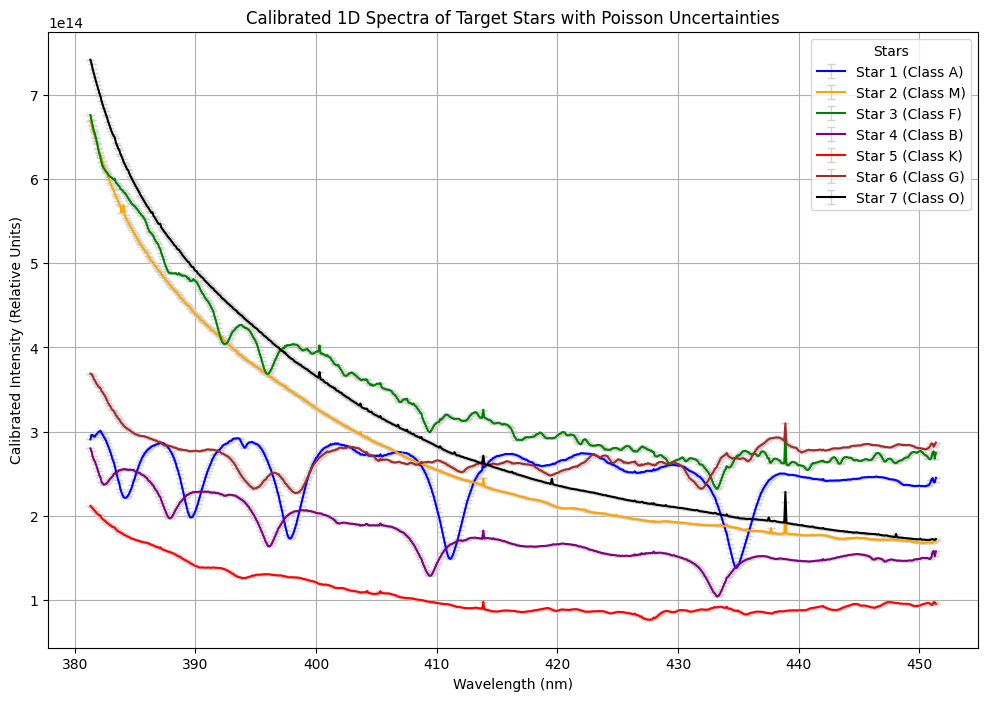

Dip 1: Wavelength = 420.46 nm, Flux = 208732833460385.38
Dip 2: Wavelength = 450.26 nm, Flux = 167209620421838.00


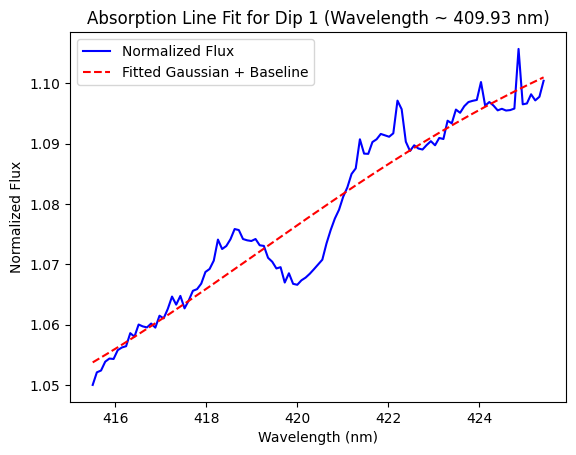

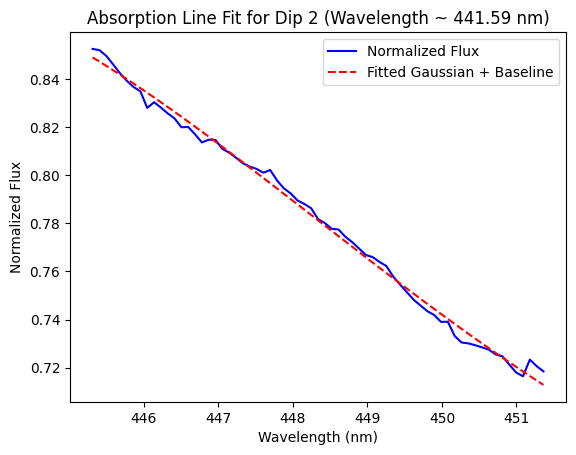

Dip 1:
  Center Wavelength (nm): 409.93
  Amplitude: -0.08
  Sigma (nm): -9.15
  Equivalent Width (nm): -0.7755

  Uncertainty in Equivalent Width (nm): -0.6245

Dip 2:
  Center Wavelength (nm): 441.59
  Amplitude: 0.27
  Sigma (nm): 6.71
  Equivalent Width (nm): 1.3244

  Uncertainty in Equivalent Width (nm): 0.4395



In [31]:
def process_second_star(calibrated_spectrum, absorption_lines):
    """
    Process the calibrated spectrum for the second star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the second star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """
    
    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 2 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_2_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the second star
absorption_lines = {
    "dip 1": (419, 420.5),
    "dip 2": (445, 451)
}

# Process all spectra and get the calibrated spectrum for the second star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_second_star = calibrated_spectra[1]  # Get the second star's calibrated spectrum

# Now, process the second star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_second_star(calibrated_spectrum_second_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[1], star_index=1)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### Third Star (F): Alt Per 

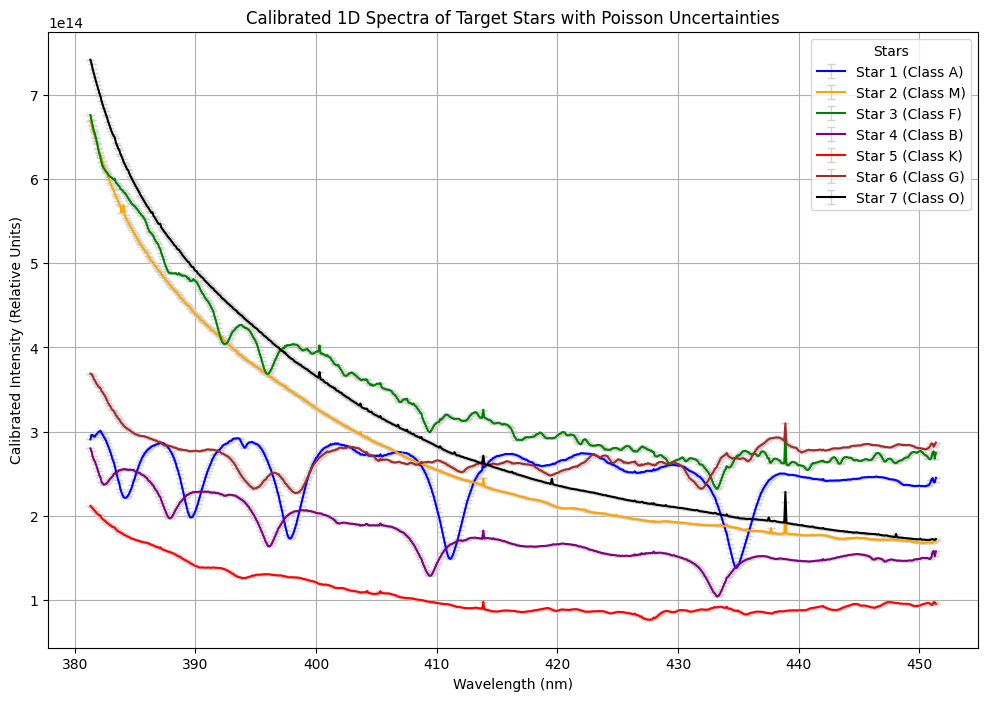

Dip 1: Wavelength = 392.39 nm, Flux = 403861176358062.75
Dip 2: Wavelength = 395.97 nm, Flux = 368448949048626.88
Dip 3: Wavelength = 409.45 nm, Flux = 299212810016252.44
Dip 4: Wavelength = 417.06 nm, Flux = 289834457197055.56
Dip 5: Wavelength = 433.20 nm, Flux = 231807050476819.84


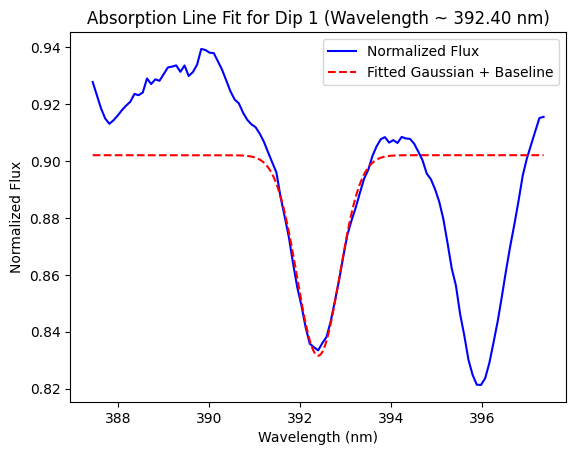

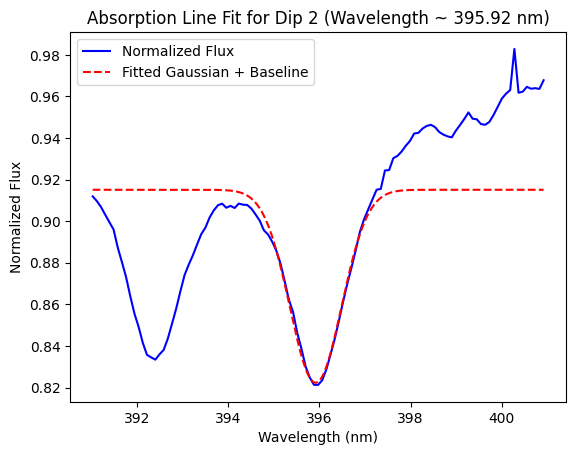

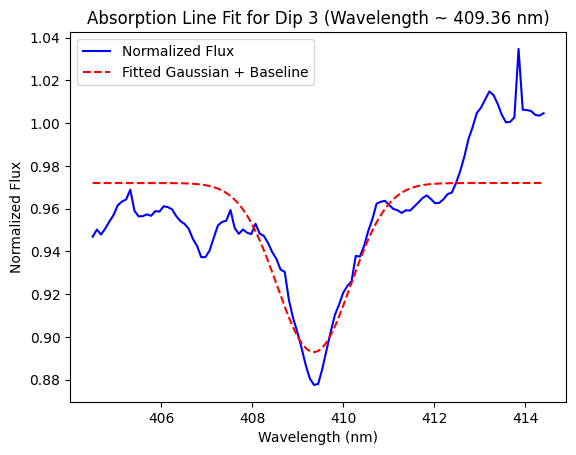

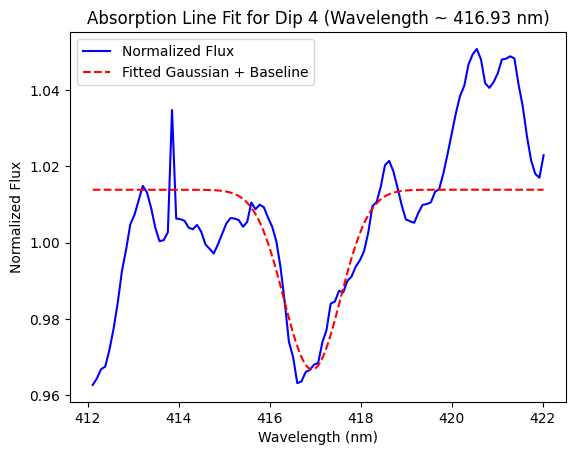

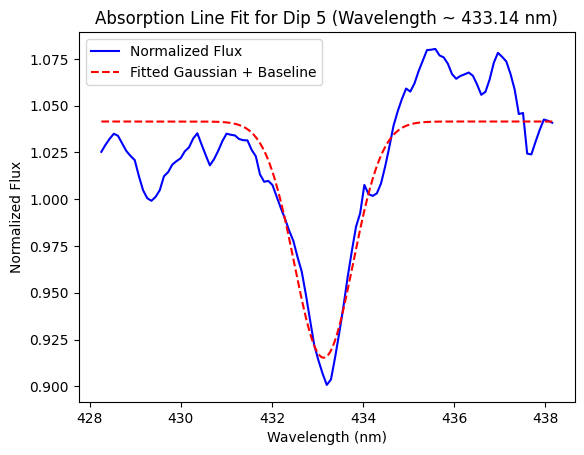

Dip 1:
  Center Wavelength (nm): 392.40
  Amplitude: -0.07
  Sigma (nm): -0.47
  Equivalent Width (nm): 1.0523

  Uncertainty in Equivalent Width (nm): 0.2808

Dip 2:
  Center Wavelength (nm): 395.92
  Amplitude: -0.09
  Sigma (nm): 0.57
  Equivalent Width (nm): 0.9728

  Uncertainty in Equivalent Width (nm): 0.2137

Dip 3:
  Center Wavelength (nm): 409.36
  Amplitude: -0.08
  Sigma (nm): 0.81
  Equivalent Width (nm): 0.4376

  Uncertainty in Equivalent Width (nm): 0.0553

Dip 4:
  Center Wavelength (nm): 416.93
  Amplitude: -0.05
  Sigma (nm): 0.62
  Equivalent Width (nm): -0.0636

  Uncertainty in Equivalent Width (nm): -0.0141

Dip 5:
  Center Wavelength (nm): 433.14
  Amplitude: -0.13
  Sigma (nm): 0.64
  Equivalent Width (nm): -0.2086

  Uncertainty in Equivalent Width (nm): -0.0186



In [32]:
def process_third_star(calibrated_spectrum, absorption_lines):
    """
    Process the calibrated spectrum for the third star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the third star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 3 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_3_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the third star
absorption_lines = {
    "dip 1": (391, 393),
    "dip 2": (395, 397),
    "dip 3": (409, 410), 
    "dip 4": (415, 418),
    "dip 5": (432, 433.5)
}

# Process all spectra and get the calibrated spectrum for the third star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_third_star = calibrated_spectra[2]  # Get the third star's calibrated spectrum

# Now, process the third star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_third_star(calibrated_spectrum_third_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[2], star_index=2)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### Star 4 (B): Bet Per 

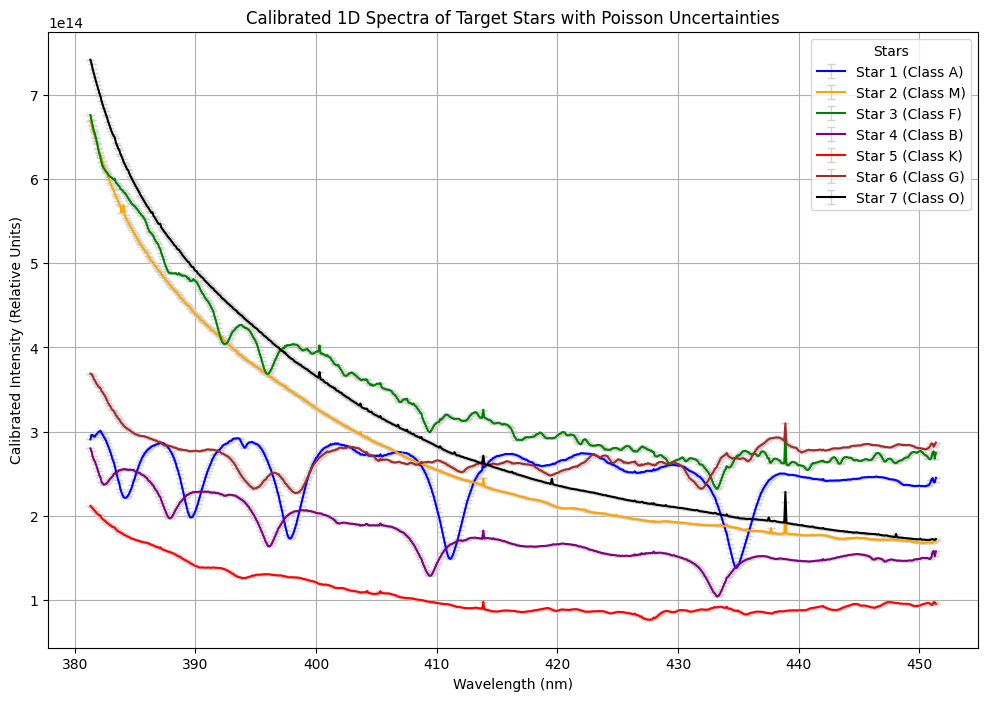

Dip 1: Wavelength = 382.40 nm, Flux = 236878971150460.19
Dip 2: Wavelength = 387.90 nm, Flux = 196744573195348.72
Dip 3: Wavelength = 396.06 nm, Flux = 163364641998907.88
Dip 4: Wavelength = 409.45 nm, Flux = 128369975535028.45
Dip 5: Wavelength = 433.20 nm, Flux = 103884090278915.95


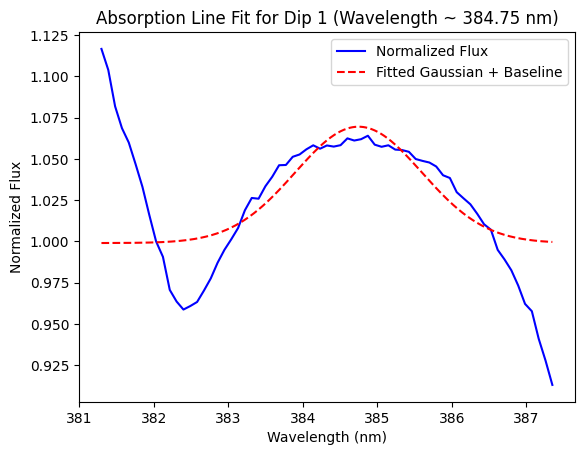

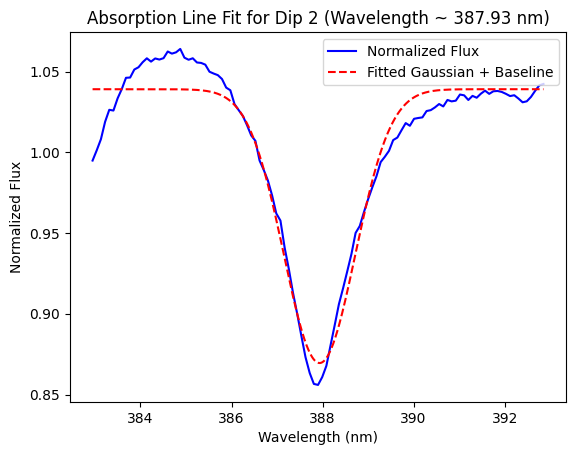

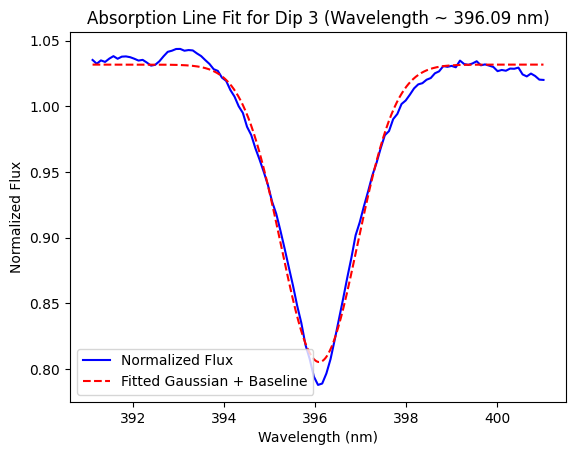

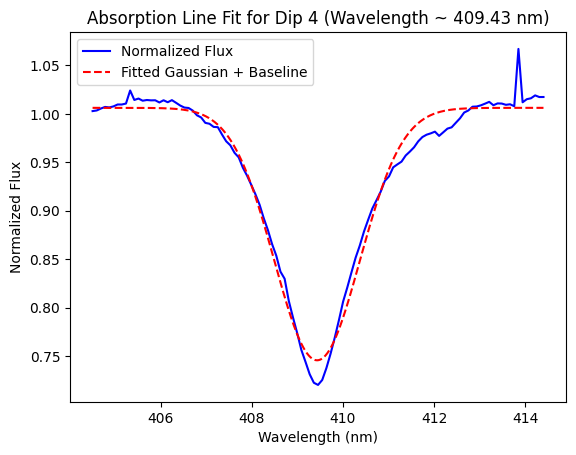

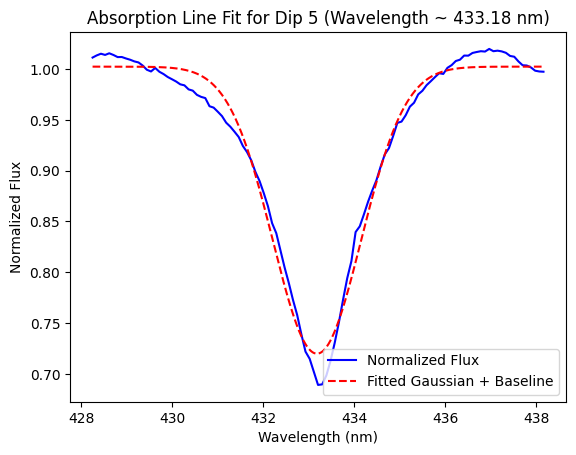

Dip 1:
  Center Wavelength (nm): 384.75
  Amplitude: 0.07
  Sigma (nm): 0.85
  Equivalent Width (nm): -0.1439

  Uncertainty in Equivalent Width (nm): -0.0419

Dip 2:
  Center Wavelength (nm): 387.93
  Amplitude: -0.17
  Sigma (nm): 0.78
  Equivalent Width (nm): -0.0544

  Uncertainty in Equivalent Width (nm): -0.0021

Dip 3:
  Center Wavelength (nm): 396.09
  Amplitude: -0.23
  Sigma (nm): 0.84
  Equivalent Width (nm): 0.1622

  Uncertainty in Equivalent Width (nm): 0.0026

Dip 4:
  Center Wavelength (nm): 409.43
  Amplitude: -0.26
  Sigma (nm): 0.94
  Equivalent Width (nm): 0.5512

  Uncertainty in Equivalent Width (nm): 0.0132

Dip 5:
  Center Wavelength (nm): 433.18
  Amplitude: -0.28
  Sigma (nm): 0.97
  Equivalent Width (nm): 0.6625

  Uncertainty in Equivalent Width (nm): 0.0153



In [33]:
def process_fourth_star(calibrated_spectrum, absorption_lines):
    """
    Process the calibrated spectrum for the fourth star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the fourth star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 4 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_4_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the fourth star
absorption_lines = {
  "dip 1": (382, 383),
  "dip 2": (386, 388),
  "dip 3": (395, 397),
  "dip 4": (409, 410),
  "dip 5": (432, 434)
}

# Process all spectra and get the calibrated spectrum for the fourth star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_fourth_star = calibrated_spectra[3]  # Get the fourth star's calibrated spectrum

# Now, process the fourth star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_fourth_star(calibrated_spectrum_fourth_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[3], star_index=3)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### Star 5 (K): Alf Cas 

##### Bad Data #2

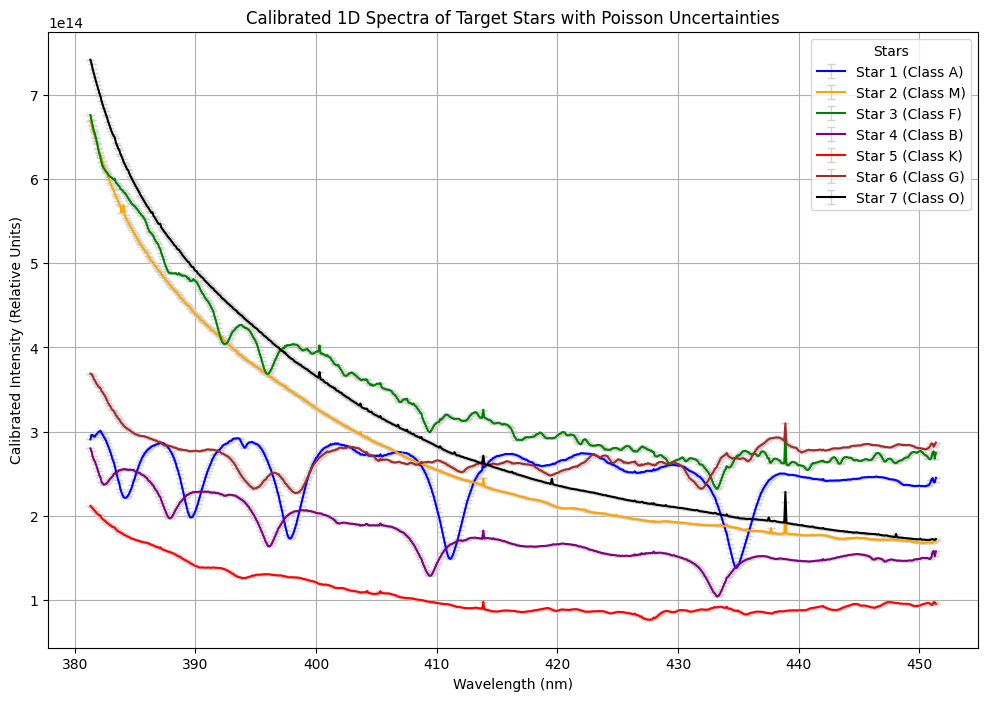

Dip 1: Wavelength = 390.47 nm, Flux = 138251488027517.92
Dip 2: Wavelength = 393.95 nm, Flux = 125674905238187.61
Dip 3: Wavelength = 427.70 nm, Flux = 76255361213637.11
Dip 4: Wavelength = 435.68 nm, Flux = 82397691947918.77
Dip 5: Wavelength = 443.20 nm, Flux = 87848333445043.84


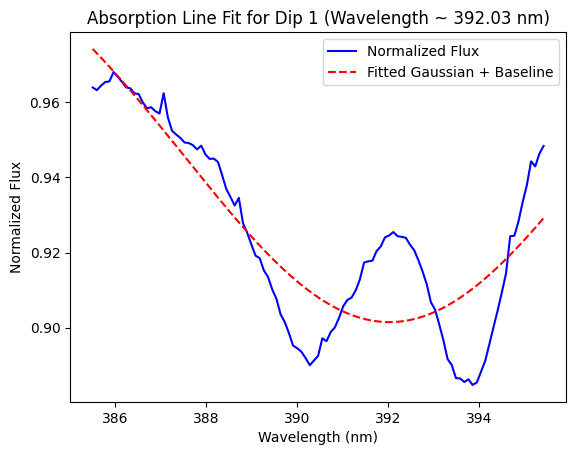

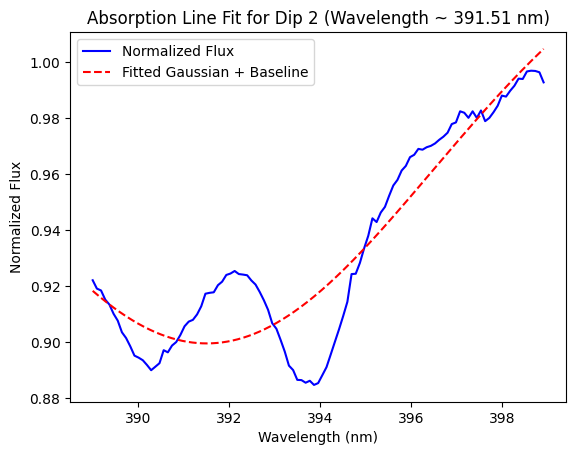

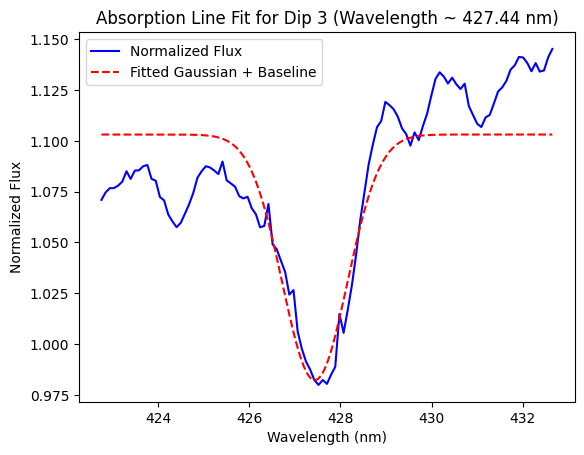

C:\Users\misha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


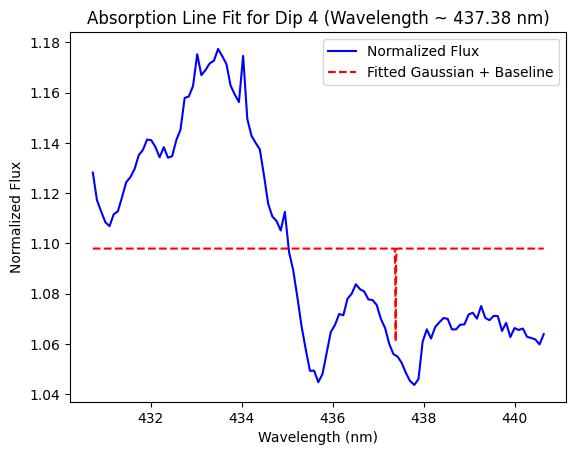

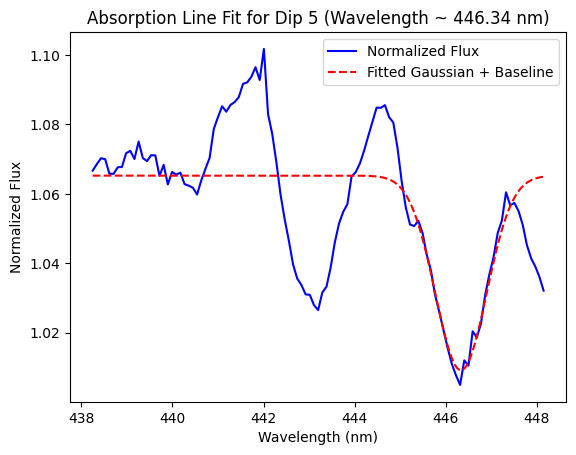

Dip 1:
  Center Wavelength (nm): 392.03
  Amplitude: -0.11
  Sigma (nm): 4.48
  Equivalent Width (nm): 0.7511

  Uncertainty in Equivalent Width (nm): 0.2832

Dip 2:
  Center Wavelength (nm): 391.51
  Amplitude: -0.16
  Sigma (nm): 4.95
  Equivalent Width (nm): 0.6607

  Uncertainty in Equivalent Width (nm): 0.1887

Dip 3:
  Center Wavelength (nm): 427.44
  Amplitude: -0.12
  Sigma (nm): 0.71
  Equivalent Width (nm): -0.8059

  Uncertainty in Equivalent Width (nm): -0.0812

Dip 4:
  Center Wavelength (nm): 437.38
  Amplitude: -0.04
  Sigma (nm): 0.01
  Equivalent Width (nm): -0.9699

  Uncertainty in Equivalent Width (nm): -inf

Dip 5:
  Center Wavelength (nm): 446.34
  Amplitude: -0.06
  Sigma (nm): -0.56
  Equivalent Width (nm): -0.5672

  Uncertainty in Equivalent Width (nm): -0.0964



In [34]:
def process_fifth_star(calibrated_spectrum, absorption_lines):
    """
    Process the corrected spectrum image for the fifth star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the fifth star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 5 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_5_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the fifth star
absorption_lines = {
   "dip 1": (389.5, 390.5),
   "dip 2": (393, 394), 
   "dip 3": (427, 428), 
   "dip 4": (435, 436),
   "dip 5": (442, 443.5)
}

# Process all spectra and get the calibrated spectrum for the fifth star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_fifth_star = calibrated_spectra[4]  # Get the fifth star's calibrated spectrum

# Now, process the fifth star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_fifth_star(calibrated_spectrum_fifth_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[4], star_index=4)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### Star 6 (G): Alf Aur; Binary System 

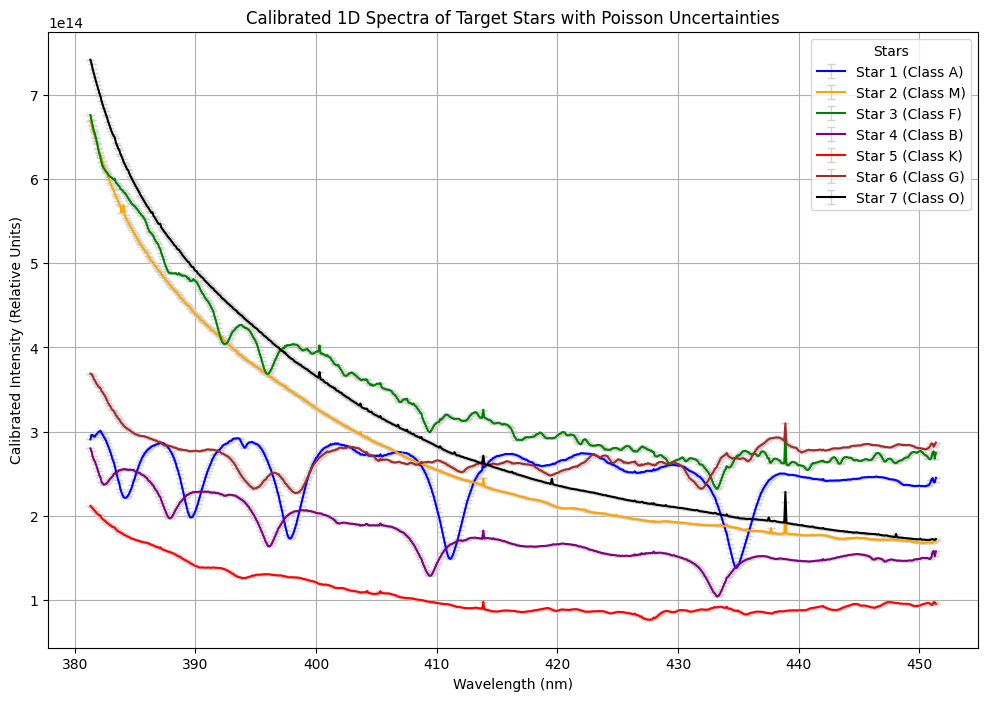

Dip 1: Wavelength = 394.78 nm, Flux = 231897242836985.81
Dip 2: Wavelength = 398.26 nm, Flux = 226977033867278.16
Dip 3: Wavelength = 412.11 nm, Flux = 251705944413675.88
Dip 4: Wavelength = 419.36 nm, Flux = 247749560749162.69
Dip 5: Wavelength = 431.92 nm, Flux = 231812532385855.84


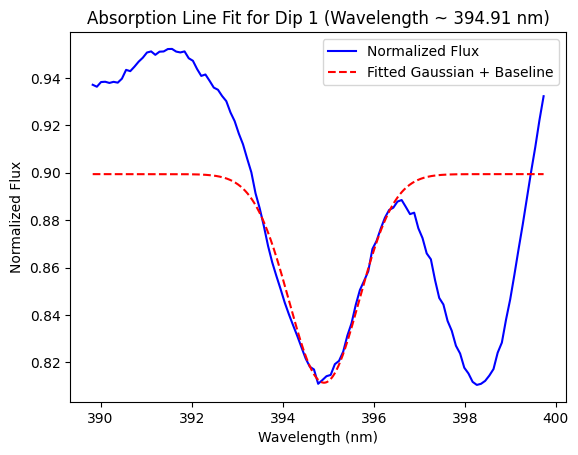

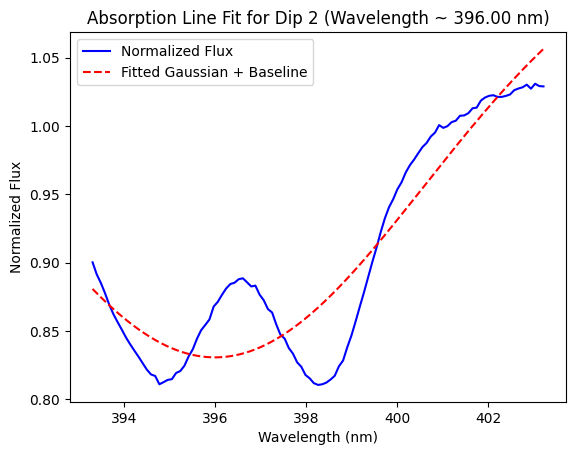

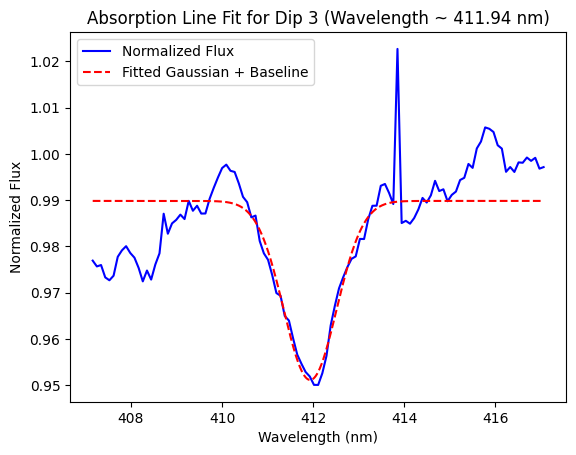

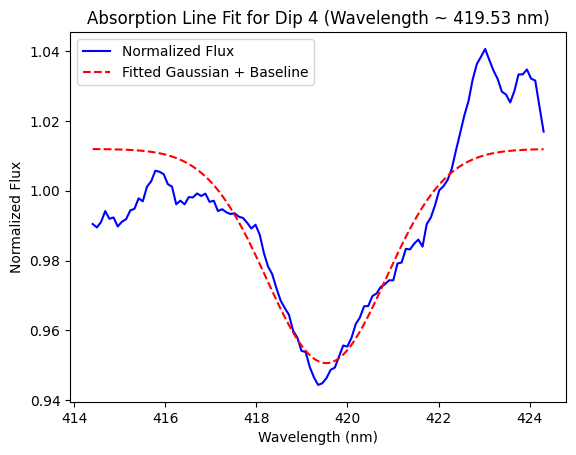

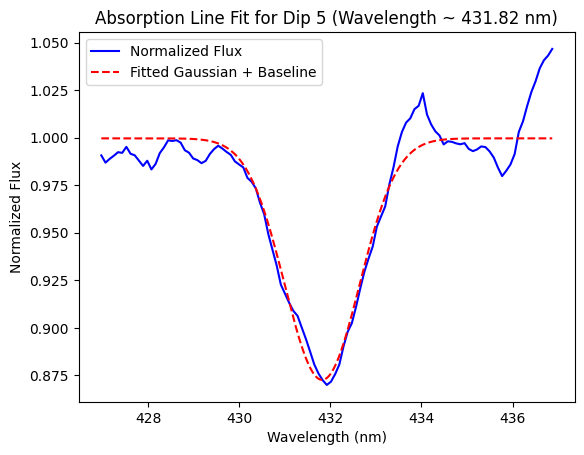

Dip 1:
  Center Wavelength (nm): 394.91
  Amplitude: -0.09
  Sigma (nm): 0.77
  Equivalent Width (nm): 1.1662

  Uncertainty in Equivalent Width (nm): 0.2876

Dip 2:
  Center Wavelength (nm): 396.00
  Amplitude: -0.32
  Sigma (nm): 4.60
  Equivalent Width (nm): 0.9533

  Uncertainty in Equivalent Width (nm): 0.2379

Dip 3:
  Center Wavelength (nm): 411.94
  Amplitude: -0.04
  Sigma (nm): 0.58
  Equivalent Width (nm): 0.1572

  Uncertainty in Equivalent Width (nm): 0.0198

Dip 4:
  Center Wavelength (nm): 419.53
  Amplitude: -0.06
  Sigma (nm): 1.31
  Equivalent Width (nm): 0.0829

  Uncertainty in Equivalent Width (nm): 0.0077

Dip 5:
  Center Wavelength (nm): 431.82
  Amplitude: -0.13
  Sigma (nm): 0.82
  Equivalent Width (nm): 0.2648

  Uncertainty in Equivalent Width (nm): 0.0135



In [35]:
def process_sixth_star(calibrated_spectrum, absorption_lines):
    """
    Process the calibrated spectrum for the sixth star, calculate flux and uncertainties,
    and identify dips.

    :param calibrated_spectrum: Tuple containing wavelengths, calibrated object flux, and Poisson uncertainties for the sixth star.
    :type calibrated_spectrum: tuple(np.ndarray, np.ndarray, np.ndarray)
    :param absorption_lines: Key absorption lines to identify dips.
    :type absorption_lines: dict
    :return: Tuple containing wavelengths and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 6 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_6_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the sixth star
absorption_lines = {
   "dip 1": (393.5, 395),
   "dip 2": (397, 399), 
   "dip 3": (412, 415), 
   "dip 4": (418, 420), 
   "dip 5": (431, 433)
}

# Process all spectra and get the calibrated spectrum for the sixth star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_sixth_star = calibrated_spectra[5]  # Get the sixth star's calibrated spectrum

# Now, process the sixth star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_sixth_star(calibrated_spectrum_sixth_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[5], star_index=5)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### Seventh Star (O): ksi Per 

##### Bad data #3 

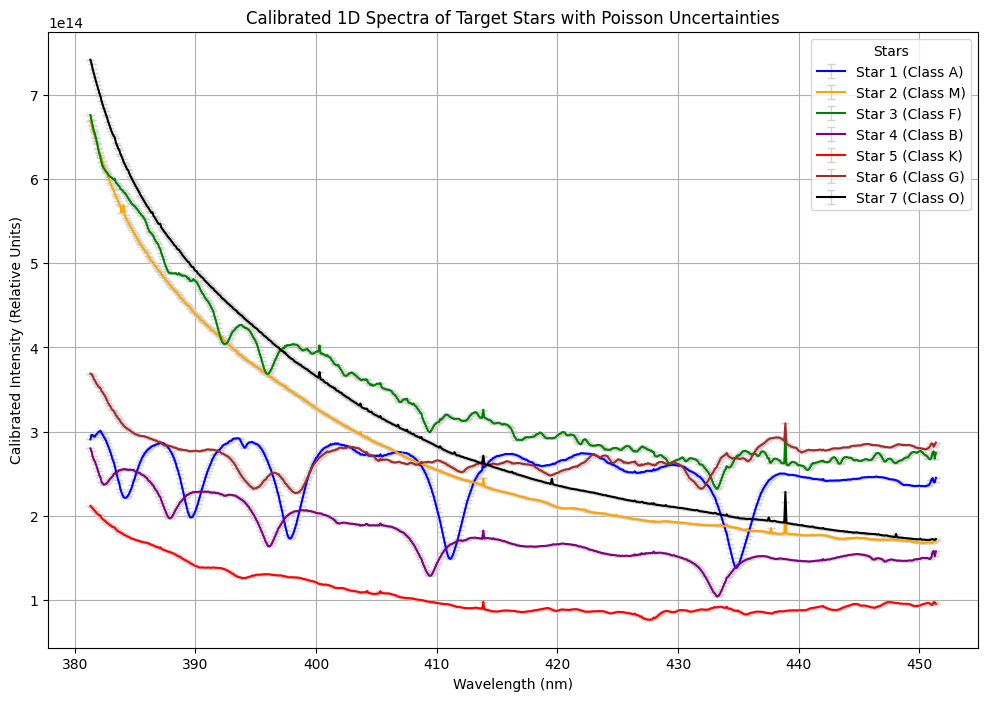

Dip 1: Wavelength = 411.93 nm, Flux = 270811775859157.97
Dip 2: Wavelength = 435.68 nm, Flux = 195836433937374.34


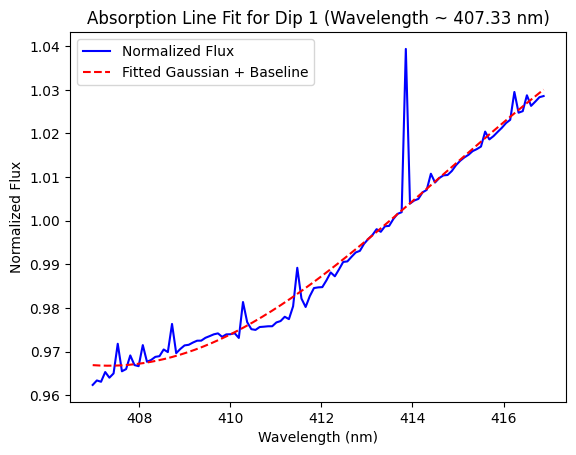

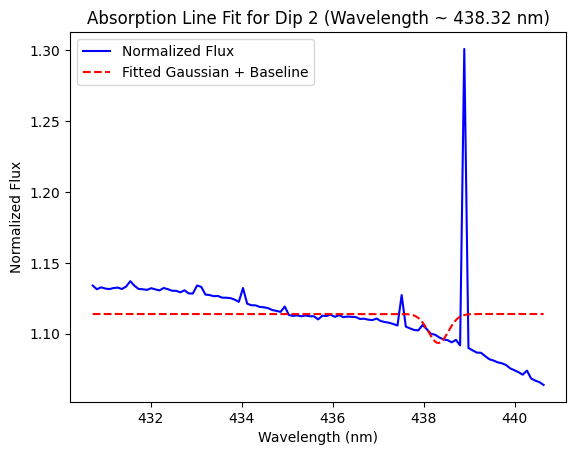

Dip 1:
  Center Wavelength (nm): 407.33
  Amplitude: -0.11
  Sigma (nm): 7.21
  Equivalent Width (nm): 0.0919

  Uncertainty in Equivalent Width (nm): 0.0268

Dip 2:
  Center Wavelength (nm): 438.32
  Amplitude: -0.02
  Sigma (nm): 0.22
  Equivalent Width (nm): -1.1168

  Uncertainty in Equivalent Width (nm): -1.3411



In [36]:
def process_seventh_star(calibrated_spectrum, absorption_lines):
    """
    Process the corrected spectrum image for the seventh star, calculate flux and uncertainties,
    convert to wavelengths, apply d_lambda, and save plot with identified dips.

    :param corrected_spectrum_image: Corrected spectrum image for the seventh star.
    :type corrected_spectrum_image: np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param d_lambda: The d_lambda values.
    :type d_lambda: np.ndarray
    :return: Tuple containing wavelengths, calibrated object flux, and list of identified dips (wavelength, flux).
    :rtype: tuple(np.ndarray, np.ndarray, list(tuple(float, float)))
    """

    wavelengths, calibrated_object_flux, poisson_uncertainties = calibrated_spectrum

    # List to store identified dips (wavelength, flux)
    identified_dips = []

    # Initialize a flag to indicate if a dip has been plotted
    dip_plotted = False

    # Plot the calibrated object flux with uncertainties
    plt.figure(figsize=(10, 6))
    plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                 label='Calibrated Object Flux with Poisson Uncertainty', 
                 color='green', ecolor='lightgray', elinewidth=1, capsize=3)

    # Identify and plot the lowest point for each specified range
    for line, (start, end) in absorption_lines.items():
        # Get the indices within the wavelength range
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Find the lowest point within the range (minimum flux)
            min_index_in_range = np.argmin(calibrated_object_flux[indices_in_range])
            # Get the corresponding wavelength and flux for the minimum
            min_wavelength = wavelengths[indices_in_range][min_index_in_range]
            min_flux = calibrated_object_flux[indices_in_range][min_index_in_range]
            # Add the identified dip to the list
            identified_dips.append((min_wavelength, min_flux))
            # Plot the lowest point within the range
            plt.scatter(min_wavelength, min_flux, color='red', marker='x', 
                        label='Significant Dips' if not dip_plotted else "")
            dip_plotted = True  # Set the flag to True after plotting

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated 1D Spectrum for Star 6 with Identified Lowest Points')
    plt.grid(True)
    plt.legend()
    # Save the plot as a PNG file
    plt.savefig('calibrated_star_7_lowest_points.png')
    plt.close()

    return wavelengths, identified_dips, poisson_uncertainties

# Absorption lines to identify dips for the sixth star
absorption_lines = {
   "dip 1": (410, 412),
   "dip 2": (434, 436)
}

# Process all spectra and get the calibrated spectrum for the sixth star
calibrated_spectra = process_all_spectra(corrected_spectra_images, coefficients, d_lambda)
calibrated_spectrum_sixth_star = calibrated_spectra[6]  # Get the sixth star's calibrated spectrum

# Now, process the sixth star's calibrated spectrum
wavelengths, dip_points, poisson_uncertainties = process_sixth_star(calibrated_spectrum_sixth_star, absorption_lines)

# Output the identified dip points
for i, (wavelength, flux) in enumerate(dip_points, 1):
    print(f"Dip {i}: Wavelength = {wavelength:.2f} nm, Flux = {flux:.2f}")

# Extract object and sky flux for the first star's spectrum
object_flux, sky_flux = extract_target_sky_flux(corrected_spectra_images[6], star_index=6)
# Convert pixel positions to wavelengths (nm) using the provided coefficients
wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
# Multiply the object flux by d_lambda for calibration
calibrated_object_flux = converted_object_flux * d_lambda
# Normalize the spectrum to its continuum using the identified dip points
normalized_flux = normalize_spectrum_to_continuum(wavelengths, calibrated_object_flux, degree=2, dip_points=dip_points)
# Measure the absorption lines around the dip points
line_measurements = measure_absorption_lines(wavelengths, normalized_flux, dip_points)

# Print out the results
for dip, measurements in line_measurements.items():
    print(f"{dip}:")
    print(f"  Center Wavelength (nm): {measurements['center_wavelength']:.2f}")
    print(f"  Amplitude: {measurements['amplitude']:.2f}")
    print(f"  Sigma (nm): {measurements['sigma']:.2f}")
    print(f"  Equivalent Width (nm): {measurements['equivalent_width']:.4f}\n")
    print(f"  Uncertainty in Equivalent Width (nm): {measurements['equivalent_width_uncertainty']:.4f}\n")

##### 3.2: Line Strength vs. T

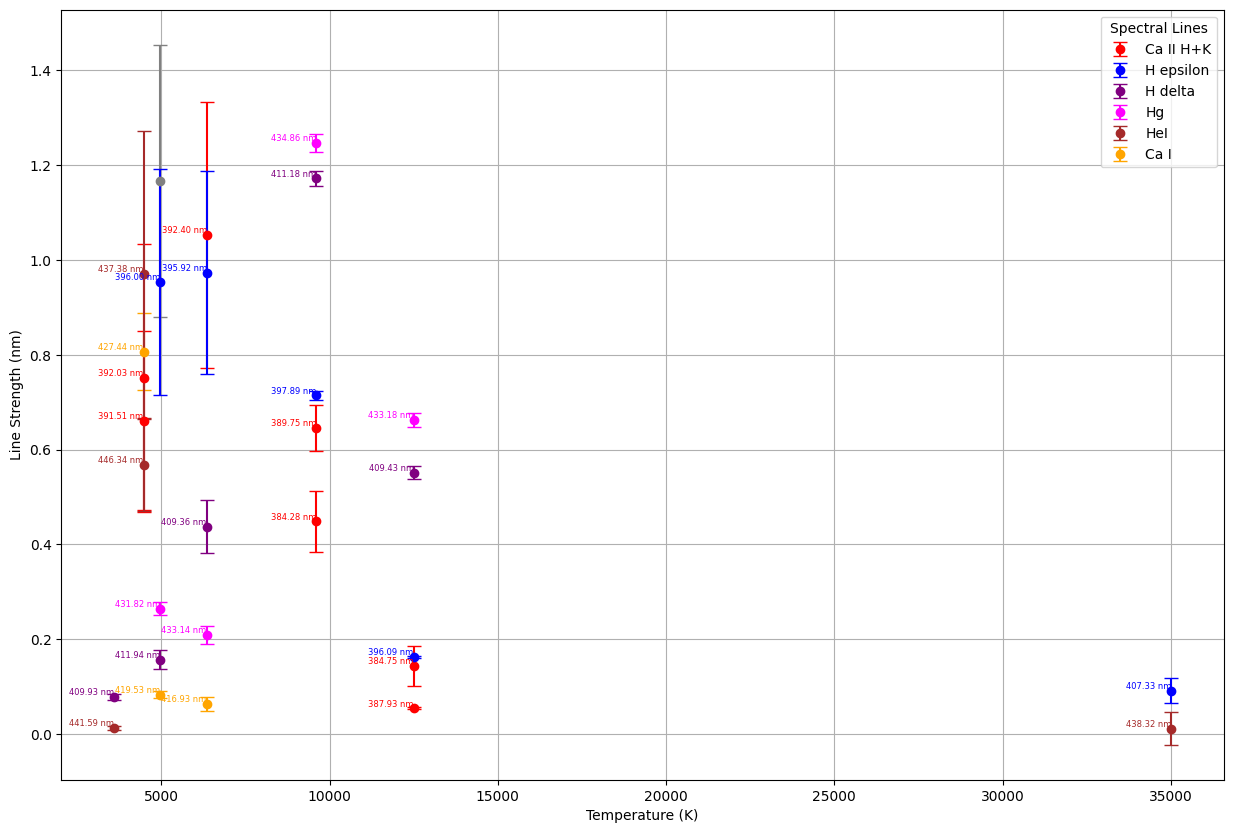

In [37]:
# Star data with temperatures, equivalent widths, their uncertainties, and wavelengths
star_data = {
    'A': {
        'temperature': 9602,
        'equivalent_width': [0.4484, 0.6459, 0.7141, 1.1717, 1.2464],
        'equivalent_width_uncertainties': [0.0633, 0.0485, 0.0085, 0.0168, 0.0191],
        'wavelengths': [384.28, 389.75, 397.89, 411.18, 434.86]
    },
    'M': {
        'temperature': 3600,
        'equivalent_width': [0.078, 0.013],
        'equivalent_width_uncertainties': [0.0062, 0.0043],
        'wavelengths': [409.93, 441.59]
    },
    'F': {
        'temperature': 6350,
        'equivalent_width': [1.0523, 0.9728, 0.4376, 0.0636, 0.2086],
        'equivalent_width_uncertainties': [0.2808, 0.2137, 0.0553, 0.0141, 0.0186],
        'wavelengths': [392.40, 395.92, 409.36, 416.93, 433.14]
    },
    'B': {
        'temperature': 12500,
        'equivalent_width': [0.1439, 0.0544, 0.1622, 0.5512, 0.6625],
        'equivalent_width_uncertainties': [0.0419, 0.0021, 0.0026, 0.0132, 0.0153],
        'wavelengths': [384.75, 387.93, 396.09, 409.43, 433.18]
    },
    'K': {
        'temperature': 4475,
        'equivalent_width': [0.7511, 0.6607, 0.8059, 0.9699, 0.5672],
        'equivalent_width_uncertainties': [0.2832, 0.1887, 0.0812, 0.3023, 0.0964],
        'wavelengths': [392.03, 391.51, 427.44, 437.38, 446.34]
    },
    'G': {
        'temperature': 4970,
        'equivalent_width': [1.1662, 0.9533, 0.1572, 0.0829, 0.2648],
        'equivalent_width_uncertainties': [0.2876, 0.2379, 0.0198, 0.0077, 0.0135],
        'wavelengths': [394.91, 396.00, 411.94, 419.53, 431.82]
    },
    'O': {
        'temperature': 35000,
        'equivalent_width': [0.0919, 0.01168],
        'equivalent_width_uncertainties': [0.0268, 0.034],
        'wavelengths': [407.33, 438.32]
    },
}

# Spectral lines data with their center and range for color coding
wavelength_lines = {
    "Ca II H+K": {"range": (382, 394.8), "color": "red"},
    "H epsilon": {"range": (394.95, 407.5), "color": "blue"},
    "H delta": {"range": (409, 416), "color": "purple"},
    "Ca I": {"range": (416, 430), "color": "orange"},
    "Hg": {"range": (431, 435), "color": "magenta"},
    "HeI": {"range": (436, 447), "color": "brown"},
    "Fe I/Ca I": {"range": (445, 464), "color": "yellow"},
    "CIII": {"range": (464, 470), "color": "cyan"},

}


# Prepare for plotting
plt.figure(figsize=(15, 10))

# Loop over each star and plot the equivalent width with uncertainties
for star, data in star_data.items():
    temp = data['temperature']
    equivalent_width = data['equivalent_width']
    equivalent_width_uncertainties = data['equivalent_width_uncertainties']
    wavelengths = data['wavelengths']
    
    for ew, ew_uncertainty, wavelength in zip(equivalent_width, equivalent_width_uncertainties, wavelengths):
        # Determine color based on spectral line ranges
        color_found = False  # Flag to check if the color has been found
        for label, line_data in wavelength_lines.items():
            low, high = line_data['range']
            if low <= wavelength <= high:
                plt.errorbar(temp, ew, yerr=ew_uncertainty, fmt='o', color=line_data['color'], capsize=5, 
                             label=label if label not in plt.gca().get_legend_handles_labels()[1] else "")
                plt.text(temp, ew, f'{wavelength:.2f} nm', fontsize=6, ha='right', va='bottom', color=line_data['color'])
                color_found = True
                break  # Exit the loop once the color is found
        
        # If no color is found, optionally mark with a default color
        if not color_found:
            plt.errorbar(temp, ew, yerr=ew_uncertainty, fmt='o', color='gray', capsize=5)

# Finalize the plot
plt.xlabel('Temperature (K)')
plt.ylabel('Line Strength (nm)')
plt.grid(True)

# Create a legend with unique spectral lines
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Spectral Lines", loc='upper right')

plt.show()